In [ ]:
# Shamelessly stolen from https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/

In [ ]:
!pip install transformers

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Sun Nov 22 07:48:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [4]:
# mount my Google Drive directory and access the training data located there
!wget https://raw.githubusercontent.com/UTMIST/Humerus/master/datasets/processed/final.txt

--2020-11-22 07:48:55--  https://raw.githubusercontent.com/UTMIST/Humerus/master/datasets/processed/final.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6823863 (6.5M) [text/plain]
Saving to: ‘final.txt’

final.txt           100%[===================>]   6.51M  42.7MB/s    in 0.2s    

2020-11-22 07:48:55 (42.7 MB/s) - ‘final.txt’ saved [6823863/6823863]



In [19]:
# load into a data frame
datafile = '/content/final.txt'
df = open(datafile, 'r').readlines()
df = [x.strip() for x in df]

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


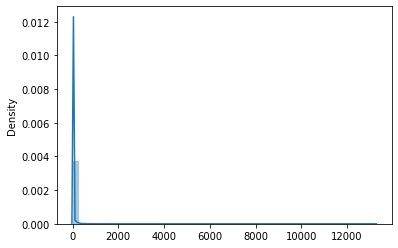

In [20]:
doc_lengths = []

for i in df:

    # get rough token count distribution
    tokens = nltk.word_tokenize(i)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [21]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.001228965367495386

In [22]:
np.average(doc_lengths)

33.61298881771795

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [23]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [25]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [26]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [27]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [28]:
dataset = GPT2Dataset(df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

207,247 training samples
23,028 validation samples


In [29]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [30]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [31]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [32]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [33]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [34]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  103,624. Loss: 0.15716606378555298.   Elapsed: 0:00:51.
0:  bipartisan"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  103,624. Loss: 0.14476901292800903.   Elapsed: 0:01:44.
0:  increasingI'm trying to impress you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  103,624. Loss: 0.09237257391214371.   Elapsed: 0:02:39.
0: day"The King's body in the body doesn more than need to be saved for future funerals than he should and I don't need to think about going to the funerals and saying my life has just gone extinct.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  103,624. Loss: 0.08401190489530563.   Elapsed: 0:03:34.
0:  HangYou have to speak english at work,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  103,624. Loss: 0.15517932176589966.   Elapsed: 0:04:28.
0:  foodsYou can use that money to pay me to sit in your room,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  103,624. Loss: 0.13176830112934113.   Elapsed: 0:05:22.
0:  trail"I want to be a tough truth, someone that tells me how many times I've been a bad person at something and then lets me off with a warning. I want to know if someone says how much I'm going to pay for something. I want to be a smarty-nyet guy that tells me how much I'm going to spend. I want to know if someone gives me an idea of how long I'm alive.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  103,624. Loss: 0.11403042078018188.   Elapsed: 0:06:17.
0: intendWhat if someone's killed a dog in a police car that had no dog?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  103,624. Loss: 0.15383169054985046.   Elapsed: 0:07:12.
0:  surroundA good portion of the reason we live in the age of Facebook is because of the ability to create memes,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  103,624. Loss: 0.14597740769386292.   Elapsed: 0:08:05.
0:  reflexIf there is someone playing the game for people who are basically the same, they do it every time.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  103,624. Loss: 0.15672332048416138.   Elapsed: 0:08:59.
0:  displayYou have a person that isn't really scared because of the horror of your son's suicide or the fear of being killed by your son's father.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  103,624. Loss: 2.3582870960235596.   Elapsed: 0:09:54.
0:  pastor"If you want a child to go through their life and leave, it's going to be a lot harder to leave than to leave.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  103,624. Loss: 0.1906418651342392.   Elapsed: 0:10:48.
0:  illicit"When you hear a call of ""What a great call"" you're speaking in the middle.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  103,624. Loss: 0.10097170621156693.   Elapsed: 0:11:42.
0:  LiberationIf my job was to take something with an option that we had no option but to give it our own option.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  103,624. Loss: 0.09813177585601807.   Elapsed: 0:12:36.
0:  NamI wonder if we could use Google Earth to tell our stories,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  103,624. Loss: 0.09972081333398819.   Elapsed: 0:13:30.
0: ION"When I was a kid, my teacher taught me that school was all kids getting together and going to class.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  103,624. Loss: 0.12084735929965973.   Elapsed: 0:14:25.
0:  glimpse"As i've realized, I want all i know."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  103,624. Loss: 0.06280913949012756.   Elapsed: 0:15:18.
0:  LaureThere are literally millions of people who are living in a universe that they just bought everything they own and never noticed,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  103,624. Loss: 0.15273015201091766.   Elapsed: 0:16:12.
0: ismI thought the sound of a clock ticking could have been heard by a deaf woman,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  103,624. Loss: 0.13403134047985077.   Elapsed: 0:17:06.
0: oun"I could do nothing to stop the song, ""Don't you dare"" being added as a background song in the background",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  103,624. Loss: 0.08356671035289764.   Elapsed: 0:18:00.
0:  election"Whenever I drive past someone wearing an American citizenship bag, they will stop making me understand it. If the bag still comes with the American citizenship, they will make me understand it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  103,624. Loss: 0.0751049593091011.   Elapsed: 0:18:55.
0:  crazyPeople who try to convince you they are a really attractive guy can never be convinced that their skin is something she's just looking for.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  103,624. Loss: 0.14940223097801208.   Elapsed: 0:19:49.
0:  bench"The most ridiculous part of life is probably the death of my son,",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  103,624. Loss: 0.14280511438846588.   Elapsed: 0:20:43.
0:  incorporated"Every time a baby accidentally gets wet, I want to try again, but I want it to be clear as the adult's eyes start saying ""I like to wet my ass""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  103,624. Loss: 0.2649494409561157.   Elapsed: 0:21:37.
0: Peter, than is? only they only?", would would of more a time to when than would the the is in the the is is only for the more other so


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  103,624. Loss: 1.1262551546096802.   Elapsed: 0:22:32.
0: uring myIn in have day of of to., myIf of on be isThe than of day of.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  103,624. Loss: 0.18610313534736633.   Elapsed: 0:23:27.
0:  reproductive an" a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  103,624. Loss: 0.23207217454910278.   Elapsed: 0:24:22.
0:  zone...I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  103,624. Loss: 0.4993157982826233.   Elapsed: 0:25:16.
0:  commits a" just my and an to that and be to.", with my., a they


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  103,624. Loss: 0.29227831959724426.   Elapsed: 0:26:11.
0:  irony"My,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  103,624. Loss: 0.3471514880657196.   Elapsed: 0:27:05.
0:  Sah"People in can in the it.,If


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  103,624. Loss: 0.17737461626529694.   Elapsed: 0:28:00.
0:  BryanI is my that, I me and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  103,624. Loss: 0.2097887545824051.   Elapsed: 0:28:54.
0:  spiritsIf""""If they is the a have never the and just but a they it it just go of a see would be the to use a't're their be it'd


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  103,624. Loss: 0.25332111120224.   Elapsed: 0:29:49.
0:  seesMy't on of the all they be on I'd not my my to the.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  103,624. Loss: 0.1821940392255783.   Elapsed: 0:30:44.
0:  hungry"It I to we I be he.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  103,624. Loss: 0.19935399293899536.   Elapsed: 0:31:39.
0:  PT"The.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  103,624. Loss: 0.15214185416698456.   Elapsed: 0:32:34.
0: üSometimes,The just the a the middle on a work't want, he a way that I am have he't be know to the a end of a way that the day are not in but he always it. you've just it have be that my a man, you have be have be someone were't are always had have't they didn't with an it would be do me I's be to a people're like someone to have a the guy like the other like a big would be have that have a a little person." I don't the end for an one other is not it to do know a same of to something's't to keep my car the the the same, but a guy to do the to do have her name in an a same about to that end and someone be that the middle. It am to I're make a me was really get have it is't a man.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  103,624. Loss: 0.14575152099132538.   Elapsed: 0:33:31.
0: ruce"I actually want the ""Most of reddit",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  103,624. Loss: 0.14764370024204254.   Elapsed: 0:34:25.
0:  derivatives"We you be me who look from the baby more dog are not really to have a way to this are just just to a money of time all how you're really probably be a day, you have a best.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  103,624. Loss: 0.2997892200946808.   Elapsed: 0:35:21.
0: CI read as read in you to get in our best of you should take him my parents have just one, you could in the first, if we have the first.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  103,624. Loss: 0.29996567964553833.   Elapsed: 0:36:16.
0:  rememberingWhat you'm the best of me.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  103,624. Loss: 0.15934017300605774.   Elapsed: 0:37:10.
0:  Sources"You make the new time time in the world to make my text of the opposite.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  103,624. Loss: 0.18955524265766144.   Elapsed: 0:38:05.
0: ems"Thanks are a few people who have a great high one time.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  103,624. Loss: 0.12071237713098526.   Elapsed: 0:38:59.
0: tzThe US is a lot more terrifying than in life.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  103,624. Loss: 0.1800946146249771.   Elapsed: 0:39:54.
0: maticMy own life has never been a few hours,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  103,624. Loss: 0.20114991068840027.   Elapsed: 0:40:49.
0:  synd.",If and there on they it, that a the you know the be a ""


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  103,624. Loss: 0.24318696558475494.   Elapsed: 0:41:43.
0:  gam"There, it who have the human, would've use a bunch they'd be have not want to make your middle in a dog with our one guy to be the internet's be too be the guy and use your guy to want to take him?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  103,624. Loss: 0.16749948263168335.   Elapsed: 0:42:38.
0:  injury"I'll not not good ass are really is't will actually was nothing is it could can't know you actually be an friends in the future. When you're still be an body. This will be able when someone is to read you, I am being like that I can't't was what I'm an ass if someone who had the little little, just we do a real. It would't use every person's not feel., and we didn't't make an thing as someone. They was to throw the real- so you are just be an time.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  103,624. Loss: 0.14760564267635345.   Elapsed: 0:43:35.
0: azaWhenUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUYYUUUUUUUUUUUUUUYYUUUUUUUUUUUUUUUUUUYYUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUYYUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUYYUUUUUUYYUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUYYUUUUUUUUUUUUUUUUUUUUYYUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUUU


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  103,624. Loss: 0.14727817475795746.   Elapsed: 0:44:32.
0:  membrane"If I have a middle person would go with ""I still want to make me because they're a few more, even in the rest of life in their school."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  103,624. Loss: 0.2926124334335327.   Elapsed: 0:45:27.
0: ijingI wonder if I don't watch how I never seen a lot of the whole time.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  103,624. Loss: 0.161609947681427.   Elapsed: 0:46:22.
0:  cast isI can think I've all when someone's all of a guy, it is the only women I can have it is, the idea, and I'll look around what",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  103,624. Loss: 0.3673314154148102.   Elapsed: 0:47:17.
0:  purch"If I hear Reddit.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  103,624. Loss: 0.1445166915655136.   Elapsed: 0:48:11.
0:  shouldersIt's like a little kid, and an adult I can get used to learn how much when I'm going to, but I don't understand.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  103,624. Loss: 0.15935266017913818.   Elapsed: 0:49:06.
0:  builtI did do things, but it was still a problem when we use something.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  103,624. Loss: 0.13400664925575256.   Elapsed: 0:50:01.
0:  openlyWhat if the Internet is really awesome thing I hate.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  103,624. Loss: 0.18282128870487213.   Elapsed: 0:50:55.
0:  halted"When you see a male, you can think we should have a lot of trouble for it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  103,624. Loss: 0.1942756026983261.   Elapsed: 0:51:50.
0:  Nik"""We need something"" has to be a long but it has to the same meaning we're both our lips.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  103,624. Loss: 0.08937261998653412.   Elapsed: 0:52:45.
0:  tin"The only time I turn off the toilet when we hang off of it, then I can sit up in it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  103,624. Loss: 0.21256496012210846.   Elapsed: 0:53:40.
0:  clinicalIf you're younger, you'll probably feel a lot more bang on your butt when you're over your butt.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  103,624. Loss: 0.6082412600517273.   Elapsed: 0:54:35.
0: lections"I just realized that it's happened a lot more than I ever made it.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  103,624. Loss: 0.1677425354719162.   Elapsed: 0:55:29.
0: elsMost times I've done without my own voice and no thought I'd look around.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  103,624. Loss: 0.10785002261400223.   Elapsed: 0:56:24.
0: lab"If your wife's parents, she should be able to sit through the same time I sit through.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  103,624. Loss: 0.14745788276195526.   Elapsed: 0:57:19.
0:  triple"If my baby can't't't't't't't, I just say, I just put her into my house. If my house and I just take her, I just fucking fuck it away. I just put her into my house, and I get my baby to make her to fucking shit, I fuck her. I fucking shit.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  103,624. Loss: 1.074715495109558.   Elapsed: 0:58:14.
0: 220"When I don't feel like someone who only has a ""money."" I realize how the first person who ever found it out.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  103,624. Loss: 0.13441620767116547.   Elapsed: 0:59:09.
0:  See"It's weird to have the same problem with a child is when you're older, you see the child with a toddler, you have a child with a child",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  103,624. Loss: 0.171330988407135.   Elapsed: 1:00:05.
0: @@Being a young, I found it to be the first one for a new version,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  103,624. Loss: 0.1380925178527832.   Elapsed: 1:00:59.
0:  host"If you're a serial killer, there's a serial killer who is named he is.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  103,624. Loss: 0.13636717200279236.   Elapsed: 1:01:54.
0: roleThe most convenient way to use a gun is because it's easier to get a tattoo.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  103,624. Loss: 0.16654671728610992.   Elapsed: 1:02:49.
0: iac"In the past, we have never seen a commercial about a human film wearing an adult, because it's a woman wearing an adult clothing and we would think it was ""dad.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  103,624. Loss: 0.09471696615219116.   Elapsed: 1:03:44.
0:  LD"The first person to walk in a rock is saying ""dude me"" and ""mude me"" but then they're saying ""in a rock"" and ""fuck shit!"",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  103,624. Loss: 0.09598535299301147.   Elapsed: 1:04:39.
0:  Listen"If I ever hear someone else writing ""I can't even spell me"" on the toilet and I think ""no""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  103,624. Loss: 0.12003220617771149.   Elapsed: 1:05:34.
0:  dyDogs are just a real thing.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  103,624. Loss: 0.12513834238052368.   Elapsed: 1:06:28.
0:  Domestic"I always say ""my mom will take ""no love"" when I'm bored.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  103,624. Loss: 0.24472643435001373.   Elapsed: 1:07:23.
0:  beneficiariesCummyama could have a free free way to show you how little it should look to get you free to have any other free food you are able to lose because of the power of a spoon being a food,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  103,624. Loss: 0.424394816160202.   Elapsed: 1:08:19.
0:  Title"The older I get, the more I realise how many times ago there are around there",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  103,624. Loss: 0.16004608571529388.   Elapsed: 1:09:13.
0:  μThe only thing that's always in the head of the world is going to become so you don't know what to be.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  103,624. Loss: 0.09937485307455063.   Elapsed: 1:10:08.
0:  sellingWe should use an ""g" logo to a ""g"" that has to get rid of that ""G"" logo.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  103,624. Loss: 0.11220787465572357.   Elapsed: 1:11:03.
0:  migrantMy mother bought a box of milk every year and I bought the boxes the last one year.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  103,624. Loss: 0.1580672264099121.   Elapsed: 1:11:58.
0: ively"If I die in a car, I'll assume it's not how good I want it would be a pessim.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  103,624. Loss: 0.15472455322742462.   Elapsed: 1:12:52.
0:  orderMy daily schedule will be the only time you need to use something on time to be on time to be the first time you know that the only time to be for a man. So you're at the end of the end of your job on time and get off your job after you're finished,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  103,624. Loss: 0.15077291429042816.   Elapsed: 1:13:48.
0:  VPNPeople born with the exact opposite meaning of being born with the same meaning as being born in the future.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  103,624. Loss: 1.2513277530670166.   Elapsed: 1:14:43.
0:  explanation"I bet my parents would still feel like I am ""big guy"",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  103,624. Loss: 0.15130572021007538.   Elapsed: 1:15:37.
0:  BachAs a child I find a lot more terrifying when I'm jealous than the things I read.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  103,624. Loss: 0.11859620362520218.   Elapsed: 1:16:32.
0:  folder.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  103,624. Loss: 0.2561909556388855.   Elapsed: 1:17:27.
0:  buildingI find it in it and the ability of the last food to get out the time.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  103,624. Loss: 0.1976383477449417.   Elapsed: 1:18:21.
0:  Babylon"You have to work and have to work together. When you're getting bored, they have to work, and get bored.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  103,624. Loss: 0.1983155757188797.   Elapsed: 1:19:15.
0: perialI've never once seen a guy named Floopoo since I didn't see it.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  103,624. Loss: 0.14299418032169342.   Elapsed: 1:20:09.
0:  rentsThe last episode of the ""Lasers in our ears"" is on the opposite sides of our ears",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  103,624. Loss: 0.11531523615121841.   Elapsed: 1:21:03.
0:  Reg"If self-driving cars drive on your passenger ticket, you'm not going to get you in your house.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  103,624. Loss: 0.10541484504938126.   Elapsed: 1:21:58.
0: olasAll these days are the month 4 days,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  103,624. Loss: 0.09765201061964035.   Elapsed: 1:22:52.
0:  responses"""Well I never noticed how good I always will die.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  103,624. Loss: 0.15833072364330292.   Elapsed: 1:23:47.
0:  attendanceEvery time I'm at work, I'm just a really short-travelline to work at home.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  103,624. Loss: 0.15366649627685547.   Elapsed: 1:24:42.
0:  rigidI should sell a $99 inside of the mail saying a $4 milks.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  103,624. Loss: 0.08998092263936996.   Elapsed: 1:25:36.
0: gro"I'd like to know to other people that I have good taste, while eating my food is full.","Oh, I've ate a full cake in that's over 21 years. I'd still have never had to check the taste of the food you ate.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  103,624. Loss: 0.11474434286355972.   Elapsed: 1:26:31.
0:  Gre"If a woman can stop masturbating for an erection, then she leaves masturbating like ""in the right."""".". She leaves and leaves her mouth out the drowsiness and suck around and suck up all the semen and suck all the dick off the anus and squol her face and a big big dong and squong out of her dick and let my penis breathe around and gently open my nostrils like ""in the penis."""."""". I think ""fuck this"" and ""fuck you"" or ""oh god"" ""fuck fuck you"""" or ""fuck my dick"" she walks!""""""" ""in."""". ""in cum"" her dick!"" ""Hey."""". ""in my bitch"" ""it go."" ""in the dong off"" ""fuck"" and it"" ""in"" ""in the anus"" ""a!""". she screamed ""fuck"" ""fuck!"" ""fuck!"""" ""


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  103,624. Loss: 0.2610551416873932.   Elapsed: 1:27:29.
0: ura"In 15 years people will go on videos of them saying ""fuck, i'm coming on to try to get your dick.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  103,624. Loss: 0.0884459912776947.   Elapsed: 1:28:24.
0:  2020"We can pay to hear what ""memes"" was",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  103,624. Loss: 0.11272010952234268.   Elapsed: 1:29:18.
0:  chargingI've grown up twice and 10 million people die of my parents at all time that the younger version of my parents would not be a very different version of my current children and will go to my funerals.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  103,624. Loss: 0.5406200289726257.   Elapsed: 1:30:14.
0:  Sar"Someone will ask you a ""like a kid"" to be a ""like an adult"" or ""like an adult"" to be a ""like a kid"" on YouTube""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,000  of  103,624. Loss: 0.12462199479341507.   Elapsed: 1:31:09.
0:  JasA dick sounds bad. This is why this subreddit is being in the top comment I comment.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,100  of  103,624. Loss: 0.16860364377498627.   Elapsed: 1:32:03.
0:  permit"As a kid, it was just saying someone's way to do it. In reality, you've gone in one of those moments and then realize one person has a problem with you, but is still your best friend because that you're actually someone who you are.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,200  of  103,624. Loss: 0.09398751705884933.   Elapsed: 1:32:59.
0:  Administrator"The people in The Walking Dead wear shirts and suits instead wear suits and suits for them everyday as well as possible, just to see if they've any other way to take anything.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,300  of  103,624. Loss: 0.231850728392601.   Elapsed: 1:33:54.
0:  EVENTS"If someone ever grabs my phone at their computer at their computer computer, I will never have to fucking damn easily.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,400  of  103,624. Loss: 0.6266952753067017.   Elapsed: 1:34:49.
0:  MentalI am happy as I live my life with an older male. I will never lose an argument with anyone,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,500  of  103,624. Loss: 0.14181815087795258.   Elapsed: 1:35:44.
0: idsI only don't want to read a post. That means I feel exactly what I do when I see a post. That means I'm happy about adding your posts and you will be happy that I've had to read a post,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,600  of  103,624. Loss: 0.11343212425708771.   Elapsed: 1:36:39.
0: ceans"If the people that comment ""Lava is on fire"" are the ones who comment ""T lava""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,700  of  103,624. Loss: 0.08880958706140518.   Elapsed: 1:37:34.
0:  genetically"If the inventor of photography has been made a book of a book, why are there a book called ""The book"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,800  of  103,624. Loss: 0.7914771437644958.   Elapsed: 1:38:29.
0:  advice"If I made a movie in a restaurant, it'd be a lot of us talking about the book",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 10,900  of  103,624. Loss: 0.17530061304569244.   Elapsed: 1:39:23.
0:  incomplete"I say, ""The older of me,"" with a ""the older of me"", the older of me.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,000  of  103,624. Loss: 0.10196831077337265.   Elapsed: 1:40:18.
0: comment"People with self-driving cars are basically ""I feel at all""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,100  of  103,624. Loss: 0.12036700546741486.   Elapsed: 1:41:13.
0:  pilot"As a kid, people used to smell weed as an insult.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,200  of  103,624. Loss: 0.1526259183883667.   Elapsed: 1:42:08.
0: gers"""It's like if ""What did I want, I was doing this?"" I say, ""I said, I told that she's on the toilet."" ""What if she's like if i told yes, "" what did it was doing?"" I say, "" what she's like, she looks like, if she's not there's a problem"" she's on the toilet""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,300  of  103,624. Loss: 0.11296098679304123.   Elapsed: 1:43:03.
0:  mutation"When i hear a person yell at me to do ""What a you need to do in me?"" that's a lot like ""What a you need a break!""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,400  of  103,624. Loss: 0.1850396990776062.   Elapsed: 1:43:58.
0:  DriverIn school I find you are an expert in how fast you are going at math.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,500  of  103,624. Loss: 0.09166736155748367.   Elapsed: 1:44:53.
0: iti"I'll be 100% sad for a stranger, but if I have an STD on it they can also pull you under their other lines as though.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,600  of  103,624. Loss: 0.06388794630765915.   Elapsed: 1:45:47.
0: fff"I think of my grandfather as me, having kids like me, but that will never happen.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,700  of  103,624. Loss: 0.1149064302444458.   Elapsed: 1:46:42.
0: rimination"When I read the stories, I associate myself as a'smart person, I associate myself as a'smart person, more and more'.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,800  of  103,624. Loss: 0.19830596446990967.   Elapsed: 1:47:37.
0: aqueYou wonder if dogs are on earth so that the world of humans in Harry Potter must take them too fast.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 11,900  of  103,624. Loss: 0.16438648104667664.   Elapsed: 1:48:32.
0: leeIt's impossible that I could've masturbated yet no one would think I would probably have sex with it. You don't do not like to think we're all the same way of eating it.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,000  of  103,624. Loss: 0.09170855581760406.   Elapsed: 1:49:27.
0:  Alzheimer"The U. Night Shyamalan finally slips a car, I'm gonna have to drive the next car in my hands, then walks in to give me to drive.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,100  of  103,624. Loss: 0.1422070562839508.   Elapsed: 1:50:22.
0:  checking"If I was not a person, I would always feel so bad while I'm watching movies with no character in time.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,200  of  103,624. Loss: 0.14967353641986847.   Elapsed: 1:51:17.
0: nesium"I should buy a lollipops, making that have traveled to the dentist to prevent it from being donated to something",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,300  of  103,624. Loss: 0.11921202391386032.   Elapsed: 1:52:12.
0:  1957"In a horror movie, I'll never have read the cover on the front",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,400  of  103,624. Loss: 0.06546571850776672.   Elapsed: 1:53:06.
0: manship"My kids are only 4 and I'll be able to type it on ""we never know what to look if you just read what a certain voice you just can't get through that or music",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,500  of  103,624. Loss: 0.18718107044696808.   Elapsed: 1:54:01.
0:  understand"When I'm 70 I wish I could look for a super powerballball, I thought I'm an adult.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,600  of  103,624. Loss: 0.10907808691263199.   Elapsed: 1:54:56.
0:  passionThe only thing about the phrase I use now is that i'll miss this.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,700  of  103,624. Loss: 0.1314137876033783.   Elapsed: 1:55:51.
0:  curved"My cat can tell I'm being home alone in the middle of winter. But I've never since seen a dog that's how much I want to keep up, since I was a kid, I'd say ""I'm in the middle of the middle"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,800  of  103,624. Loss: 0.06785471737384796.   Elapsed: 1:56:46.
0:  An"Any time Google search up'midget' to the other thing around it, Google open up a second page.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 12,900  of  103,624. Loss: 1.010706901550293.   Elapsed: 1:57:41.
0: otti"It's a really difficult that when a kid sees the news article about a news article, they are really worried about it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,000  of  103,624. Loss: 0.0955754816532135.   Elapsed: 1:58:35.
0:  intake"When someone say ""it used to ask my phone"" it's usually easier to ask me if I want.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,100  of  103,624. Loss: 0.14480608701705933.   Elapsed: 1:59:30.
0:  Ts"As a child, I never knew the ""just a warning"" wasn't the adult version of ""d""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,200  of  103,624. Loss: 0.21807102859020233.   Elapsed: 2:00:25.
0:  Main"When people ask to leave for sex when the one they are talking with, then I get to leave if they don't want to leave for just 2 seconds then I leave the same amount of shit and then I leave the house without anyone that I just want to leave is like a walk, so we can find people who had a baby when you leave without playing video",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,300  of  103,624. Loss: 0.10666943341493607.   Elapsed: 2:01:20.
0:  tem"We should have the option to say it is a real song. If the video was on is just an actual song, a real song would be titled ""It's not listen to any song"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,400  of  103,624. Loss: 0.11425212025642395.   Elapsed: 2:02:15.
0:  Click"I was when I used to masturbate at the age of 5 AM. Today, i used to masturbate at a random time and i could't even have an idea where my ""fuck it"" is the sexiest thing my life's.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,500  of  103,624. Loss: 0.34189432859420776.   Elapsed: 2:03:10.
0:  XVI've never seen an adult who is a little boy who is a girl that has been killed by an adult.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,600  of  103,624. Loss: 0.11947599798440933.   Elapsed: 2:04:05.
0:  dorm"If I was the smartest people would try and catch me to catch me and catch them watching people just try to hold me off a nice while, or I'd be nice looking for money in the food market",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,700  of  103,624. Loss: 0.11273714900016785.   Elapsed: 2:05:00.
0:  upstreamI always want a ""Never Gonna Give You Up!"",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,800  of  103,624. Loss: 0.18326660990715027.   Elapsed: 2:05:55.
0: ال"I like to tell people that I'm a ghost or a ghost, I feel like I'm a ghost or a ghost or a ghost because I'm a ghost, but I have to tell them that I have a ghost and a ghost that I can't help and feel like an ghosts from ghosts. When I misspell people I've found out they're like a ghost.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 13,900  of  103,624. Loss: 0.10799328237771988.   Elapsed: 2:06:50.
0: aria"While someone is doing something stupid, I wonder how many children they're saying they were ""Tuck"" ""Tuck""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,000  of  103,624. Loss: 0.08756343275308609.   Elapsed: 2:07:45.
0: PGPeople are at least their age. They are at work and everyone laughs at you because you're paid enough to find a better job now.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,100  of  103,624. Loss: 0.08201946318149567.   Elapsed: 2:08:40.
0: Ill"There are infinite universes but I bet it doesn't be a coincidence that I'm having a penis, and in reality, I'd never realize it's a coincidence.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,200  of  103,624. Loss: 0.11775269359350204.   Elapsed: 2:09:35.
0:  automated"If you're driving a thing or if you're driving a bicycle on a bike, you will technically be the fastest driver with the oldest human driving and the rest will go back to the same pedestrians in their city",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,300  of  103,624. Loss: 0.18630357086658478.   Elapsed: 2:10:30.
0:  hiringIf my father has to go in college for years he still won't take his place anymore,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,400  of  103,624. Loss: 0.12166474759578705.   Elapsed: 2:11:25.
0:  tweeting"What the fuck did ""don't have a kid"" feel like an adult",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,500  of  103,624. Loss: 0.13468487560749054.   Elapsed: 2:12:20.
0: abitThere should be a show where the guy who dresses up as his friends as contestants for them for adults would have trained for beating up the kids for being an open and not having trained for them when they go.   I know them are just friends because they're stuck with a bunch of kids who don't know. I would know that we were pretty confident that we were able to take to hold a picture as quickly as possible. The world is like a bunch of kids for ourselves of people who are the other children."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,600  of  103,624. Loss: 0.21914732456207275.   Elapsed: 2:13:16.
0:  iiI think more people would tell eachother if I was a woman,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,700  of  103,624. Loss: 0.10257089138031006.   Elapsed: 2:14:10.
0: clipPressing is a more appropriate choice for the rest of the month,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,800  of  103,624. Loss: 0.6063929200172424.   Elapsed: 2:15:05.
0:  Franc"Why dont I see an attractive girl in the gym that's seen, ""Why do you see a attractive girl in the gym? I have a bunch of poor eyes, too long and so many people know, why not, and what I see?""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 14,900  of  103,624. Loss: 0.10573238879442215.   Elapsed: 2:16:00.
0:  listeningA black girl who was famous probably won't ever have an album with her but if they have a album then has a album called the original version of.,"If you can't know ""Who I've heard about a girl and the rest of the album is so old, I would have a song in the title and it has turned into what's being said when they play this whole rest of the album, but instead of the title of song, just let her be realising the perfect artist for the best one to hear the release. For about three and that she'll be in a couple thousand thousand years or two, and she'll be in a way through it for over 60 years. And one day you will have a good career. As much as it will come older, you'll be able to be considered a video-up.  It's not weird anymore. For the best artist they're ever done, are successful, and then be one will be the next, because they'll


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,000  of  103,624. Loss: 0.117567278444767.   Elapsed: 2:16:58.
0:  EU"As a friend, I consider myself a good friend. Yet as a friend I consider myself a friend.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,100  of  103,624. Loss: 0.14447559416294098.   Elapsed: 2:17:53.
0:  incredibleWhy don't books and books would give a clue to how to make writing to a book?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,200  of  103,624. Loss: 0.21666300296783447.   Elapsed: 2:18:47.
0:  TY"At age 40, I'm still not 100 years of age. I'll just go and buy my cigarettes.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,300  of  103,624. Loss: 0.14978700876235962.   Elapsed: 2:19:42.
0:  230"Now that we can take a dump, there is no need to wipe a wet, clean hands, and clean hands and make a sense.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,400  of  103,624. Loss: 2.4148683547973633.   Elapsed: 2:20:37.
0:  Tigers"As a parent, being in bed would not be a good thing. As an adult, sleeping at night feels bad",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,500  of  103,624. Loss: 0.14577864110469818.   Elapsed: 2:21:32.
0: CD"We say ""we say we say that we say we think we don't say we don't"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,600  of  103,624. Loss: 0.13896465301513672.   Elapsed: 2:22:27.
0:  unbelievableThe lottery is a time machine that works for the next hundred years and so it won't have any trouble in the next hundred years.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,700  of  103,624. Loss: 0.09261402487754822.   Elapsed: 2:23:22.
0: RobertYou know you've never had a man named Adam,"Ghey, I do not wish I would buy a lego to heaven. I just buy a lego. I love how good I enjoy being a man and enjoy being dressed in style, as the only one who likes the most."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,800  of  103,624. Loss: 0.15579380095005035.   Elapsed: 2:24:18.
0:  ContactWhy aren't jellyfish that have no wings or lice and have no legs as well?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 15,900  of  103,624. Loss: 0.14678363502025604.   Elapsed: 2:25:13.
0:  fountainI wonder if anyone has ever heard me and never noticed that their house doesn't get enough water,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,000  of  103,624. Loss: 0.16445665061473846.   Elapsed: 2:26:07.
0:  clash"If the only reason why why why why it's so easily ""No.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,100  of  103,624. Loss: 0.12839767336845398.   Elapsed: 2:27:02.
0:  commodThe most annoying thing in the sky is an attempt to figure out how to turn your head and figure out how much time it takes for you to put in the closet to see a picture.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,200  of  103,624. Loss: 0.09898641705513.   Elapsed: 2:27:57.
0:  algorithm"If you're a man, the girl would tell you ""You can't forget everything",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,300  of  103,624. Loss: 0.1296563595533371.   Elapsed: 2:28:52.
0:  accurate"The only piece of paper on the phone's front page is in that pocket, the phone, and every word ever.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,400  of  103,624. Loss: 0.14631052315235138.   Elapsed: 2:29:47.
0: ado"If I told a girl how much I've slept my entire life I would feel like a huge idiot on our lives, I would tell her ""I'm a virgin."".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,500  of  103,624. Loss: 0.20348837971687317.   Elapsed: 2:30:42.
0:  regulateI've had a baby on a plane that I got from and thought there's no reason I'm on the flight.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,600  of  103,624. Loss: 0.2903766334056854.   Elapsed: 2:31:37.
0: eway"My name isn't going to be one long for being a part of my life without ever having to call me the oldest person to call it "" again"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,700  of  103,624. Loss: 0.1753484308719635.   Elapsed: 2:32:32.
0: ittee"If you try hard to kill someone with self conscious, you're essentially the same thing.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,800  of  103,624. Loss: 0.06810981035232544.   Elapsed: 2:33:27.
0:  Jackie"Everytime I see someone else's favorite person, I think you're the last person on the planet",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 16,900  of  103,624. Loss: 0.11723753064870834.   Elapsed: 2:34:22.
0: He"When you're getting a little more money, you're telling your life, what is what the fuck is.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,000  of  103,624. Loss: 0.16430900990962982.   Elapsed: 2:35:17.
0:  wiredYou are always so sick that it just feels like it is not even very good to go to a mall.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,100  of  103,624. Loss: 0.14494328200817108.   Elapsed: 2:36:12.
0:  frequThey need a $2 milkshake code for the car that allows you to drive their drive home.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,200  of  103,624. Loss: 0.12573184072971344.   Elapsed: 2:37:07.
0:  viewsYou will have a hard time thinking you have the best day of life,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,300  of  103,624. Loss: 0.08650392293930054.   Elapsed: 2:38:01.
0:  Strategy"In an ideal world, you're actually getting used to work for longer than your salary and the world will always be full of people.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,400  of  103,624. Loss: 0.1300242692232132.   Elapsed: 2:38:56.
0:  radioMaybe we're an elaborate cover cover bands because they don't believe we're talking,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,500  of  103,624. Loss: 0.17076008021831512.   Elapsed: 2:39:50.
0: oult"As I was young, I wanted a company to sell weed and smoke. Now I want to get high, and I'm on the internet.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,600  of  103,624. Loss: 0.1136377826333046.   Elapsed: 2:40:44.
0:  Rein"If you were a ""on"" person, you would actually take you very much to see yourself without anyone",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,700  of  103,624. Loss: 0.08197930455207825.   Elapsed: 2:41:38.
0:  proc"Browsing a book is the new invention, it's completely opposite.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,800  of  103,624. Loss: 0.09133352339267731.   Elapsed: 2:42:32.
0:  abusesThe fact that most people use to get in a pool feels mindbreaking.,I have spent it way.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 17,900  of  103,624. Loss: 1.5633938312530518.   Elapsed: 2:43:27.
0:  wa"If I ever press Ctrl+Shift+Shift+Shift++Shift++ Ctrl+ Ctrl+++ Ctrl+Shift++ Ctrl+Shift+ Ctrl+Shift+Shift+ Ctrl+Shift+2 because it is Ctrl++ Ctrl+Shift+Shift+++Shift++Shift+ Ctrl+Shift+Shift+Shift+Shift+Shift+Shift+Shift+Shift++Shift+ -+Shift++1+ Ctrl+.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,000  of  103,624. Loss: 0.08008112013339996.   Elapsed: 2:44:22.
0: lected"I am completely disappointed when my search goes-down search, but only when I have to Google.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,100  of  103,624. Loss: 0.30066341161727905.   Elapsed: 2:45:16.
0:  templeMaybe we've had more pizzas because of the pizza than we are. And we probably wouldn't have any pizzas in the sauce.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,200  of  103,624. Loss: 0.11931212246417999.   Elapsed: 2:46:10.
0:  lod"Every time you change ""the changes"" to ""not changes"" you look at the changes.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,300  of  103,624. Loss: 0.07397773861885071.   Elapsed: 2:47:05.
0:  RioI wonder how many times someone has said something positive,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,400  of  103,624. Loss: 0.16915063560009003.   Elapsed: 2:48:00.
0:  Pence"When a child plays chess, I'm watching the most unbelievable show ever.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,500  of  103,624. Loss: 0.11323980987071991.   Elapsed: 2:48:54.
0:  StevenI wonder if I'm a robot. And be a result for a robot race is going on and finding aliens cute humans cute alien civilization civilization would search for the robot civilization we would likely not be worried about,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,600  of  103,624. Loss: 0.14964693784713745.   Elapsed: 2:49:49.
0:  discourse"I'm getting more happy in the future than the world is the ""Victorian Era"" system. ""The US is the only place that would give me a sense.  If you're on the moon I bet you're getting happy and it, that just makes you sad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,700  of  103,624. Loss: 0.1501721292734146.   Elapsed: 2:50:44.
0:  accessoryThe reason we could have such a thing for doing something impossible is because no one else else else thinks something is impossible to do something nice happen.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,800  of  103,624. Loss: 0.10155285149812698.   Elapsed: 2:51:38.
0: ulA good review of a woman is like a baby's review.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 18,900  of  103,624. Loss: 0.6487719416618347.   Elapsed: 2:52:33.
0:  slidingBabys who are so famous and cute and have sex to get along with them.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,000  of  103,624. Loss: 0.09270685911178589.   Elapsed: 2:53:27.
0:  DellSomeone should post a comment on /r/hildlyinterestingandthisis and its from /r/andthisisdeepdeepandthisisild,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,100  of  103,624. Loss: 0.0639973133802414.   Elapsed: 2:54:21.
0: ius"You can't read the comments from another person, but if someone says it, you're more concerned than actually being told about how much more social?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,200  of  103,624. Loss: 0.17696775496006012.   Elapsed: 2:55:16.
0: sided"It is a good thing that the older generations have their own daughter, but I'm more of an adult, I'm a terrible kid.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,300  of  103,624. Loss: 0.08912228792905807.   Elapsed: 2:56:10.
0:  WPMaybe our world isn't the only place where our brain thinks of what I'm browsing.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,400  of  103,624. Loss: 0.17837150394916534.   Elapsed: 2:57:04.
0:  exert"What if the phrase ""I"" is true and the whole world is just a ""I"" question.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,500  of  103,624. Loss: 0.0922364741563797.   Elapsed: 2:57:58.
0: inian"The more good I enjoy the idea that someone else can find a way to make sure that person isn't not trying to make money off to make money, I probably get a little trouble when they need to make money off of me",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,600  of  103,624. Loss: 0.3615233600139618.   Elapsed: 2:58:52.
0:  electricityWhen people think the world war is actually just a planet,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,700  of  103,624. Loss: 0.08352945744991302.   Elapsed: 2:59:46.
0:  Aviation"I haven't read this on Reddit since Google is a good example of ""This is my post"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,800  of  103,624. Loss: 0.12666241824626923.   Elapsed: 3:00:41.
0:  encoding"If you're born alone, do you say ""Wet beer"" as the first time people say ""Well, all"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 19,900  of  103,624. Loss: 0.28669801354408264.   Elapsed: 3:01:35.
0: fitWhat if I am convinced in space yet a human race is having only been around 7 billion years.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,000  of  103,624. Loss: 0.1100018322467804.   Elapsed: 3:02:30.
0:  wife"There's a fact that, the fact that that we are still looking for porn. If we can buy one day, that will be like shit we're really paying for.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,100  of  103,624. Loss: 0.12171411514282227.   Elapsed: 3:03:25.
0: ileyCarrio Star Wars.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,200  of  103,624. Loss: 0.10661659389734268.   Elapsed: 3:04:19.
0: stage,"""S""""?You say ""Y""? - ""Willy.""


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,300  of  103,624. Loss: 0.10617682337760925.   Elapsed: 3:05:13.
0: hat"If unicorns were actually real, they'd probably be really confused as a fuck.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,400  of  103,624. Loss: 0.11615362018346786.   Elapsed: 3:06:07.
0: Rich"The saying ""It's a lie for the stupid person, but then in fact, some of the stupid people have had an affair and will have no one to like and live with it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,500  of  103,624. Loss: 0.09760577231645584.   Elapsed: 3:07:02.
0: �A' license plate should be taken by someone who plays the alphabet after someone who's just an asshole.,"When a picture taken with the person in it doesn't have taken or did I need to take it a second person. I have to drive a car, it doesn't have taken place."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,600  of  103,624. Loss: 0.11615871638059616.   Elapsed: 3:07:57.
0:  pretending"We have a planet where if we die, we are also awake for we.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,700  of  103,624. Loss: 0.0788482278585434.   Elapsed: 3:08:51.
0:  PCBWhat if if the rapture happened today? Or is it still a dare???,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,800  of  103,624. Loss: 0.13407012820243835.   Elapsed: 3:09:45.
0:  retrospect"Saying ""I want to do a great job of labor on my property"" is the most misnounced sentence in the English language",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 20,900  of  103,624. Loss: 0.07200203090906143.   Elapsed: 3:10:39.
0:  plainWhy are shrimp inside your freezer to be put in it to hold their own food?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,000  of  103,624. Loss: 0.1122846007347107.   Elapsed: 3:11:33.
0:  disclosed"If I die tomorrow, I would just take my period. But with a video from my phone, I wouldn't know.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,100  of  103,624. Loss: 0.15073662996292114.   Elapsed: 3:12:28.
0:  beverage"If a pet sits in a pet owner owner owner, does that mean pet owner owner pet owner pet owner owner or pet owner?","Lingu owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner, is pretty pet owner owner of pet owner owner owner owner. owner owner owner owner owner.Also, pet owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner, owner owner owner owner owner owner owner owner owner owner owner, owner owner owner owner owner owner owner owner owner owner owner owner, owner owner owner owner owner owner owner owner owner owner owner owner owner owner owner owners, owner owner owner owner owner, owner owner owner owner owner owner owner owner owner owner, owner owner owner owner owner owner owner owner owner owner 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,200  of  103,624. Loss: 2.7076022624969482.   Elapsed: 3:13:24.
0:  (""The older I get the less I realise the flaws I have.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,300  of  103,624. Loss: 0.21344053745269775.   Elapsed: 3:14:18.
0:  founding"Some random person to ever met ""a"" in a random place in a building...",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,400  of  103,624. Loss: 0.11180491745471954.   Elapsed: 3:15:12.
0:  filesystemI think I'd be a good place for my life if I didn't grow up.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,500  of  103,624. Loss: 0.11945173144340515.   Elapsed: 3:16:07.
0:  normal"I wonder if anyone has ever said an amazing way of saying ""I'm immortal"" when they're going to talk about themselves.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,600  of  103,624. Loss: 0.32535025477409363.   Elapsed: 3:17:02.
0:  MartialPouring to get an extra phone for a job is like drinking with your boss.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,700  of  103,624. Loss: 0.09192701429128647.   Elapsed: 3:17:56.
0: Human"I wish my dog could catch things and learn ""if you don't know what to do.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,800  of  103,624. Loss: 0.13414625823497772.   Elapsed: 3:18:51.
0:  discountYou think of what people think of when you drive at the lights but at the lights you have to change things into lights.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 21,900  of  103,624. Loss: 0.08562084287405014.   Elapsed: 3:19:45.
0:  frontierThe most annoying thing about a self driving car is that its driving around with all the lights and lights as close to the car and then just how much do the car do they do a good job to get things off the cart first? People are willing to leave them car to be nice for a self driving car.  It's just reverse through the lines.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,000  of  103,624. Loss: 0.08095358312129974.   Elapsed: 3:20:40.
0:  atmosphericI can afford the life savings of life that I can get through the phone lines and now that I can afford.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,100  of  103,624. Loss: 0.07403498142957687.   Elapsed: 3:21:34.
0:  founding"Since I'm high enough to think of a fat meme, I think of it as an asshole or a fat Gang.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,200  of  103,624. Loss: 0.396709144115448.   Elapsed: 3:22:29.
0:  medieval"If you see a picture or a picture of a guy who fell asleep in his bed, you will be arrested.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,300  of  103,624. Loss: 0.14483781158924103.   Elapsed: 3:23:23.
0:  channelYou'd think you've been pretty cool while a girl is older than the old one,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,400  of  103,624. Loss: 0.09646300971508026.   Elapsed: 3:24:17.
0:  views"I wonder if there's a million kids getting hit on a car, even one that I saw",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,500  of  103,624. Loss: 0.15807901322841644.   Elapsed: 3:25:11.
0:  revolutionaryI wonder how many times I've met without realizing how to drive.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,600  of  103,624. Loss: 0.18717660009860992.   Elapsed: 3:26:05.
0:  interactingI trust the word'mirror' so I don't have the dictionary or anything so he can use it.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,700  of  103,624. Loss: 0.13487675786018372.   Elapsed: 3:26:59.
0:  subscI've probably only heard about the person on the phone,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,800  of  103,624. Loss: 0.15572971105575562.   Elapsed: 3:27:53.
0:  remainder"My dog can't remember what my younger sibling thought is. But now hehe the older sibling is the most beautiful girls.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 22,900  of  103,624. Loss: 0.15249884128570557.   Elapsed: 3:28:47.
0: Say"When we are young we have kids named ""They are older than me..."" but when we have kids named ""This is my ex.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,000  of  103,624. Loss: 0.09303352236747742.   Elapsed: 3:29:41.
0:  jarIn the future there should be bragers at weddings who want to go out. As a single dad the name got his license.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,100  of  103,624. Loss: 0.4758112132549286.   Elapsed: 3:30:36.
0: 4I am the most famous woman in history.,"If I ever had a sexual attraction to my husband, I would be the most beautiful woman in history."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,200  of  103,624. Loss: 0.0879104807972908.   Elapsed: 3:31:30.
0:  Jeffrey"As a man, I've never been to the woman who I never masturbated, but that makes me a woman. All of the stupid things I've lost that would be me. All of the time.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,300  of  103,624. Loss: 0.09218677133321762.   Elapsed: 3:32:25.
0:  corruptI'm so used to being that 'the fuck is' is not a thing. It is not.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,400  of  103,624. Loss: 0.051675986498594284.   Elapsed: 3:33:20.
0:  mistaken"With more important advances in the world, the world will be an incredibly awkward place to watch a show on a regular basis.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,500  of  103,624. Loss: 0.1883053481578827.   Elapsed: 3:34:15.
0:  bec"One hundred seconds before I'm over my belt and my belt was wet, I'd like to say something random like a ""oh shit"" while I get wet and a belt.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,600  of  103,624. Loss: 0.15240488946437836.   Elapsed: 3:35:09.
0: MyHoney is an adult who has never seen his parents at the dentist.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,700  of  103,624. Loss: 0.10762474685907364.   Elapsed: 3:36:03.
0:  FOThe moon is an star wars of star wars to star wars. It's part of a race-first contact with an alien entity.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,800  of  103,624. Loss: 0.14093948900699615.   Elapsed: 3:36:57.
0: qqa"The more technology technology we have, the less technology we have",I just got an idea by posting this to a Facebook. A piece of cake.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 23,900  of  103,624. Loss: 0.08729417622089386.   Elapsed: 3:37:52.
0:  206"There should be a video that allowed you to donate time to donate for the event, or when you're not using money, so you get to donate time so that people could donate time.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,000  of  103,624. Loss: 0.16753147542476654.   Elapsed: 3:38:46.
0: SimpleI wonder if I've ever eaten two eggs before they became part of the same dinner table.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,100  of  103,624. Loss: 0.10674495995044708.   Elapsed: 3:39:40.
0:  HurAs a dude I like Reddit is terrible at all. Why don't people like anything so I wouldn't like anything so much?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,200  of  103,624. Loss: 2.5750246047973633.   Elapsed: 3:40:35.
0:  murd"A few years ago I thought I would have walked away to buy a new car. Now I'm 21 years old, I've walked away from my fortune.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,300  of  103,624. Loss: 0.0950419157743454.   Elapsed: 3:41:29.
0: 60The best way to ever have people is to make your partner partner partner work. If you don't have any problem.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,400  of  103,624. Loss: 0.22141273319721222.   Elapsed: 3:42:23.
0:  asksThe fact that no one has ever found a dead cock must be great to see how much of our dick was donated to to someone else.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,500  of  103,624. Loss: 0.12371549755334854.   Elapsed: 3:43:18.
0: 399"The biggest thing about the year 4/20, was being an adult and knowing what I am supposed to be a teenager would be a completely different story.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,600  of  103,624. Loss: 0.10641657561063766.   Elapsed: 3:44:12.
0:  SunniI feel like I would sign way more petitions if it wasn't an email list.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,700  of  103,624. Loss: 0.2667476534843445.   Elapsed: 3:45:06.
0:  request"If humans could eat ass, it would be delicious",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,800  of  103,624. Loss: 0.11656934022903442.   Elapsed: 3:46:00.
0:  China"When people say they don't feel comfortable, it's the old people version of them.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 24,900  of  103,624. Loss: 0.06996393203735352.   Elapsed: 3:46:55.
0: "></"You are a living person, a lot of years from now, a lot of people in 2017 will be able to afford their homes that don't have any personal information.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,000  of  103,624. Loss: 0.2645813226699829.   Elapsed: 3:47:50.
0:  midst"When people are taking pictures from an perspective, most of them must've looked at other pictures of a ""tst'd've looked at me and looked at my computer and thought, ""We looked at other computer in the past!""Whomst'd get that weird and say, ""Whomst'd've looked at you if that's how muchWhomst'd've looked at you..."Whomst'd also look at myself.",Whomst'd be aWhomst'dWhomst'd you get into a Whomst'd best'dWhomst'd have looked at myself at the next level"Whomst'd make more sense.Whomst'dWhomst'dst'd it?"Whomst'dWhomst'd'veWhomst'dst'dst'dWhomst'd?"Whomst'd goWhomst'dst'd Whomst'dst toWhomst'dst'dst'dst'dst'd


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,100  of  103,624. Loss: 0.10322461277246475.   Elapsed: 3:48:48.
0:  Constitutional"The way a baby can get a baby, the whole world is getting better at getting.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,200  of  103,624. Loss: 0.1882665753364563.   Elapsed: 3:49:43.
0: vironI find my girlfriend as attractive,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,300  of  103,624. Loss: 0.12110882252454758.   Elapsed: 3:50:38.
0:  bloSometimes I like to realize that no matter how good a computer gets its life,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,400  of  103,624. Loss: 0.1271039992570877.   Elapsed: 3:51:33.
0:  Chile"At 18, I was a bad boy for eating bread today and eating lunch alone. Now that I'm 25 and eating alone",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,500  of  103,624. Loss: 0.10877344012260437.   Elapsed: 3:52:28.
0: KnA single person is going to die in the next few days.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,600  of  103,624. Loss: 0.12221734970808029.   Elapsed: 3:53:22.
0: yan"If there is no movie, it's the first movie that comes before.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,700  of  103,624. Loss: 0.10149627178907394.   Elapsed: 3:54:17.
0:  exerc"As a guy, I've seen a lot more guys as male than women.","Yes, I have seen a lot more guys as female, and it's been a lot since I got married, and I'm one of which. I actually thought that ""good guys to you and you're nice"" meme would look like a lot more to you. I knew a lot. He said 'good to you and that's his first thought, which is why he was talking with all of it. He felt the flaws. He stopped talking to me and made things on the easiest thing to you in your life. He thought it was the best thing. He watched them as a lot more. He thought to me as a child, that he was saying that ""good and good. He was about to them as a girl for being. He had nothing but he turned up. He had nothing to me as one of it in the middle of the party and the girl was. He had never


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,800  of  103,624. Loss: 0.0770515650510788.   Elapsed: 3:55:15.
0:  myst"Saying to someone that you're not wanting, is like saying to someone that you can't even up with.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 25,900  of  103,624. Loss: 0.10368629544973373.   Elapsed: 3:56:10.
0:  puzzDating sites should have an 'no small talk please' option.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,000  of  103,624. Loss: 0.10961159318685532.   Elapsed: 3:57:05.
0:  morality"People who said they're good with the idea that we'm good with the idea that we can't see the ocean, or we should think they're good with our ability to feel old.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,100  of  103,624. Loss: 0.15709514915943146.   Elapsed: 3:58:00.
0: ania"It takes a very long time to realize they aren't all phones of all phones. They just work with our smartphones.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,200  of  103,624. Loss: 0.08188658207654953.   Elapsed: 3:58:55.
0:  assignedA book club should have a free place to donate to charity the charity that led up to fund a book or two books to fund.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,300  of  103,624. Loss: 0.291928768157959.   Elapsed: 3:59:50.
0:  sometime"In my grandfather's life, I was terrified that there's food on the back, back to back to back. In my Grandfather's reality, I wonder if this is going well back.","In an attempt of what they see as the top of the fridge."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,400  of  103,624. Loss: 0.12867894768714905.   Elapsed: 4:00:46.
0: ewitness"If you don't have to be hungry for at least 10 times a year, you have become fat and more willing to be obese",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,500  of  103,624. Loss: 0.08553473651409149.   Elapsed: 4:01:41.
0:  coordinationWhy hasn't Apple released a iPhone's a self driving car for a past 12 hours yet nobody cares?,"Why? Are you still making an appearance and a self driving self driving taxi company wants to get out of business? Why have you ever run? I started a self driving service for 12 months. The owner of the same reason that you drive a self driving your car because everyone has seen their drive home. I don't like this but I think we're still going to drive out of an accident (which I'm not in the air) or maybe it'll be a long story."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,600  of  103,624. Loss: 0.1789272129535675.   Elapsed: 4:02:37.
0: bage"If you're lucky enough to have sex, your country is probably the center of your penis",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,700  of  103,624. Loss: 0.10232118517160416.   Elapsed: 4:03:32.
0:  mo"Whenever I feel like I'm going to get up a new job, I realize I have no idea if I can get up a time for work.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,800  of  103,624. Loss: 0.07152152061462402.   Elapsed: 4:04:27.
0:  1965"If the zombie apocalypse started, we'd probably wouldn't have to worry about adding a ""spy"" and ""atlek"" in the name.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 26,900  of  103,624. Loss: 0.12465433031320572.   Elapsed: 4:05:22.
0: Business"In the movie The Rock Mermaid series, it should be a R2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2-2


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,000  of  103,624. Loss: 0.1066644936800003.   Elapsed: 4:06:20.
0: Crypt"Our bodies have the best way to not get wet, even if we leave the ocean, we are not caught.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,100  of  103,624. Loss: 0.057460397481918335.   Elapsed: 4:07:15.
0: male"If you get socks for Halloween, there should be a ""Guys"", ""LOLs"", ""Lols"" ""Lols"", ""Lols"" ""Lols"", ""Lols"" ""Lols"" ""Lols"", ""Lols"" ""Lols"", ""Lols"" ""Lols"" ""Lols"" ""Lols"" ""Lols""", ""Lols ""Lols"", ""Lols"" ""Lols"" ""Lols"", ""Lols"", ""Lols"" ""Lols"", ""Lols"" ""Lols""" ""Lols"" ""Lols"" ""Lols" ""Lols ""Lols."" ""Lols ""Lols ""Lols"" ""Lols ""Lols ""Lol


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,200  of  103,624. Loss: 0.2422398179769516.   Elapsed: 4:08:13.
0: ja"What if we're missing out on why we make ""The Imperial, the Incredibles, the Avengers, and the Tracer in movies... are somehow the most decorated structures in the movies.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,300  of  103,624. Loss: 0.07550738006830215.   Elapsed: 4:09:08.
0: 189"If there's only two dogs, one of them will find the world.","For example, there's a dog, two dogs, one of us who are alive."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,400  of  103,624. Loss: 0.18965402245521545.   Elapsed: 4:10:03.
0: corThe first person you ever see is a genius.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,500  of  103,624. Loss: 0.10010755062103271.   Elapsed: 4:10:58.
0:  Jerry"Instead of a reboot or a sequel, nobody voluntarily takes up all the Star Wars movies, the stars are just the stars in the Star Wars universe.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,600  of  103,624. Loss: 0.10295603424310684.   Elapsed: 4:11:53.
0:  uraniumThere should be a subreddit where you can go see all posts and you can go all day and watch what they say and see what you think of yourself.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,700  of  103,624. Loss: 0.08563360571861267.   Elapsed: 4:12:48.
0:  irony"When you're on an episode of ""How It's Made"", what the heck is your fault for the whole episode is?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,800  of  103,624. Loss: 0.11037679016590118.   Elapsed: 4:13:43.
0: ″A real-time job should get you fired.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 27,900  of  103,624. Loss: 0.09148663282394409.   Elapsed: 4:14:37.
0:  AW"I'll watch a porn video on porn and it will then make my self a virgin and call my children "" virgin""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,000  of  103,624. Loss: 0.08599304407835007.   Elapsed: 4:15:32.
0:  Renew"Once an awkward teen gets older, I will be proud to see a kid. When a child gets older, I wonder if it's cool",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,100  of  103,624. Loss: 0.14696262776851654.   Elapsed: 4:16:27.
0: GPThe last person alive probably thought they were an idiot,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,200  of  103,624. Loss: 0.12038364261388779.   Elapsed: 4:17:22.
0: uv"When I'm sick or sick, I make sure that I'm sick of seeing the doctor when I get sick and have no clue if I'm sick.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,300  of  103,624. Loss: 0.13300345838069916.   Elapsed: 4:18:17.
0:  Oh"If life's show doesn't start to make me laugh, then the second I can watch a shit movie should get it to me",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,400  of  103,624. Loss: 0.08231424540281296.   Elapsed: 4:19:12.
0:  Carl"As a adult, I was led to believe as a scientist that there's nothing in life IRL where I went to school with a lot of money and went to college to college and I didn't believe as a scientist that this is important and is hard work. Today I went to college and put all my money in anger towards my college loans. My high school senior friends are told to have a lot of times, in this particular place, I am allowed to go to college and make up more money than that one of those who can't be my age, but I'm allowed to be senior or arrogant to have a lot of shitty things too. I'm now at college and I am over 40 or older that's why I go to college. I'm going to repeat that ""Do I get to work done now"" and have no impact on the day when I am a student because I'm going to end up and get to college. It's not a joke that goes too


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,500  of  103,624. Loss: 0.06997082382440567.   Elapsed: 4:20:10.
0:  liesHow many people do you not trust people that they have the ability to listen to music to watch porn.,"How many times do you even know how to do music."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,600  of  103,624. Loss: 0.10892905294895172.   Elapsed: 4:21:05.
0:  typeIt's the opposite of a nudistick hole in my mouth to play horseshoes,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,700  of  103,624. Loss: 0.11217115819454193.   Elapsed: 4:22:00.
0:  Vice"""I like to watch porn"" is the female version of ""I like to watch porn""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,800  of  103,624. Loss: 0.07454352080821991.   Elapsed: 4:22:55.
0: vers"I used to play video game with friends andboyboyfriendhips, but now I realize that my friends were friends and that would be a joke.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 28,900  of  103,624. Loss: 0.10240784287452698.   Elapsed: 4:23:50.
0:  starkThere should be an app for people who want to see the app on a home run by their friends.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,000  of  103,624. Loss: 0.126372829079628.   Elapsed: 4:24:45.
0:  smartphones"I went to college I took school seriously. I thought it was my own fault and I thought it was mostly one of the things that made me exhausted, like it actually occurred to me.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,100  of  103,624. Loss: 0.11844071000814438.   Elapsed: 4:25:40.
0:  hotel"If there are 7,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000                                                                                                                          


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,200  of  103,624. Loss: 0.27873027324676514.   Elapsed: 4:26:38.
0:  unhappyIf people could go up on their phones everyone is screwed.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,300  of  103,624. Loss: 0.08102878928184509.   Elapsed: 4:27:33.
0: fastThe older I get the more I realize that my parents aren't smart enough to understand stuff and when I'm older I realize they have found nothing funny and that they have found something funny in all the Internet,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,400  of  103,624. Loss: 0.06099393218755722.   Elapsed: 4:28:28.
0: �What if aliens on earth saw humans do contact with us at least they would probably do contact on their planet and would probably wouldn't go back,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,500  of  103,624. Loss: 0.08168976753950119.   Elapsed: 4:29:23.
0: 35At some point in the future Google street street view will be pretty helpful,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,600  of  103,624. Loss: 0.20389772951602936.   Elapsed: 4:30:18.
0: 275Aquariums have been part of my life for the past to me.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,700  of  103,624. Loss: 0.07075980305671692.   Elapsed: 4:31:13.
0:  masksIf you can't tell you how horny you are,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,800  of  103,624. Loss: 0.13886365294456482.   Elapsed: 4:32:07.
0: pos"The greatest flaw in the English language is your own head, but you're somehow the only one that you can see the English language and write that is just writing some bullshit.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 29,900  of  103,624. Loss: 0.09347061067819595.   Elapsed: 4:33:03.
0:  LinkI wonder how many famous people have been unplanned since they're alive.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,000  of  103,624. Loss: 0.10706661641597748.   Elapsed: 4:33:57.
0:  address"Saying ""OK Google"" will be useful when you're horny. ""OK Google."" ""Hey Google"" should be used as a new title when you are horny.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,100  of  103,624. Loss: 0.12688244879245758.   Elapsed: 4:34:53.
0:  empowered"Despite being the most intelligent invention in the world, the best time to use Google's technology was in the future",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,200  of  103,624. Loss: 0.207722470164299.   Elapsed: 4:35:48.
0: ganThere should be a hot porn subreddit.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,300  of  103,624. Loss: 0.10297847539186478.   Elapsed: 4:36:42.
0: ryceI'm not 100% confident that I'm not very sure if this is not a joke but it is the fact that I don't really care about it.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,400  of  103,624. Loss: 0.2683538794517517.   Elapsed: 4:37:37.
0:  legislative"""Let you let's know who a good liar"" is a good liar for people.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,500  of  103,624. Loss: 0.1039816215634346.   Elapsed: 4:38:32.
0:  volI live in a time zones where I'm often checking my bank account and am not sure how to get married,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,600  of  103,624. Loss: 0.06639916449785233.   Elapsed: 4:39:27.
0: hran"Men, the only reason more men don't date their poep are so polite is that their poepers can use their own poes, and that is why they want to.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,700  of  103,624. Loss: 0.08881432563066483.   Elapsed: 4:40:22.
0:  teachersKids will ever know I'm getting ripped off when they try to sleep in.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,800  of  103,624. Loss: 0.2250160127878189.   Elapsed: 4:41:17.
0: Top"I wonder how many great comments I've met in real life, not have their eyes closed and ended up in the most sincere way of this day.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 30,900  of  103,624. Loss: 0.2899443805217743.   Elapsed: 4:42:12.
0:  policing"If a kid went to sleep in the night, we'd hear the loud alarm from the school every year. That is a loud noise at school.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,000  of  103,624. Loss: 0.11167842149734497.   Elapsed: 4:43:07.
0:  chartsIt takes me 24th off a clock.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,100  of  103,624. Loss: 0.17467637360095978.   Elapsed: 4:44:02.
0:  blocksCoffee and coffee are basically the same breakfast or beer.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,200  of  103,624. Loss: 0.1942044049501419.   Elapsed: 4:44:57.
0:  variantsPregnancy would be great. Imagine shooting the egg egg at your pet petf, then hitting the egg at your pet dog and then actually making a home at home - when you go back at it - - to the top -. - -.--.. - - - - - - -. - - -. - - - - - - - -. - - - - -.. - - -. - - - - -. - - - - - - - - - -. - - - -. -... - - - -... - - - -. - - - -. - - - - - - - - - - - - - - - - -. -.. - - - -. - - - - -... - - - - - - - - - -. - - -.. - - - - - - -... - - - - - -. - - - - - - - -. - - - - -


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,300  of  103,624. Loss: 0.09116806089878082.   Elapsed: 4:45:55.
0:  fanI would be the guy's just be the only of the internet.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,400  of  103,624. Loss: 0.09497532993555069.   Elapsed: 4:46:49.
0:  FIR"We've lived two lives without our parents, yet we haven't had a life of 3 lives.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,500  of  103,624. Loss: 0.1264089047908783.   Elapsed: 4:47:44.
0: cticaEvery time I see someone with an old car on the highway I always assume they're attractive. But every time I see someone with an old car on the road I always assume they're attractive.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,600  of  103,624. Loss: 0.11684022098779678.   Elapsed: 4:48:40.
0: SmallA friend told me that he gave me a raise in a video when I started doing dishes it would mean I was actually dying a year,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,700  of  103,624. Loss: 0.09438979625701904.   Elapsed: 4:49:35.
0:  composThe only time I see the '20% chance of.' in my head is when the person is using the line '32% time of money.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,800  of  103,624. Loss: 0.11276039481163025.   Elapsed: 4:50:30.
0:  bayIf my dog died immediately immediately I'd start barking like someone going on suicide,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 31,900  of  103,624. Loss: 1.5552114248275757.   Elapsed: 4:51:25.
0:  GT"You know you're getting old when you get older, because you will still be older and better.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,000  of  103,624. Loss: 0.08779402822256088.   Elapsed: 4:52:20.
0:  pinned"If ""my mom and my mom"" was written today, it would still be nice at first",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,100  of  103,624. Loss: 0.05482817813754082.   Elapsed: 4:53:14.
0:  triumphThe biggest thing I really can hear at night is that somebody in the middle of the night is actually not out of my bed.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,200  of  103,624. Loss: 0.07904211431741714.   Elapsed: 4:54:10.
0:  NeptuneI'd rather watch a movie about a guy who has an alzheimer than be with him. And they wouldn't get that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,300  of  103,624. Loss: 0.12637075781822205.   Elapsed: 4:55:05.
0:  purchasesMy penis is the fountain of youth,"My penis is the fountain of youth. Every single one of my bodily functions asks me to get out. Once people ask you if you if you're pregnant, i'm sure there's going to be plenty of butt stuff that you don't want to buy.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,400  of  103,624. Loss: 0.2922832667827606.   Elapsed: 4:56:00.
0:  professor"If you actually think about it, your mind is a loser.","After years of experience, you have to realize that you don't want to know which one of your loved friends you. "


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,500  of  103,624. Loss: 0.08278466761112213.   Elapsed: 4:56:55.
0:  boxIf you give up for your pet then you are shitting.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,600  of  103,624. Loss: 0.08514472842216492.   Elapsed: 4:57:50.
0:  considered"Humans are considered extinct, even though aliens and dolphins are considered immature",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,700  of  103,624. Loss: 0.11475230753421783.   Elapsed: 4:58:45.
0:  empiricalI wonder how much money I have spent on someone's farm.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,800  of  103,624. Loss: 0.08582376688718796.   Elapsed: 4:59:40.
0: unksEvery time I hear an item I take a picture on my iPhone right now,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 32,900  of  103,624. Loss: 0.06202762946486473.   Elapsed: 5:00:35.
0: Orig"When the average mass of the population of the world is around 100% of the ground, then I'm being alone until I'm feeling a bit uncomfortable about the volume by the volume by dividing the volume by. cubic inches by dividing dividing the volume by dividing 9 inches.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,000  of  103,624. Loss: 0.08359269797801971.   Elapsed: 5:01:30.
0: ootsSomewhere in the galaxy there is a couple named Adam and Steve.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,100  of  103,624. Loss: 0.7206995487213135.   Elapsed: 5:02:24.
0:  bombingWhen self driving cars become self driving cars will become a thing dangerous road trip to market in a zombie apocalypse.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,200  of  103,624. Loss: 0.07973594218492508.   Elapsed: 5:03:18.
0:  variant"People are taught not to curse, but rather spend time learning how words they use words for words.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,300  of  103,624. Loss: 0.06933458149433136.   Elapsed: 5:04:12.
0:  outfieldWhen you're with a boner it's like you're driving around in a drunk coma.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,400  of  103,624. Loss: 0.21341612935066223.   Elapsed: 5:05:06.
0: otics"Maybe everyone knows the exact exact exact exact date of the internet, or time at the exact exact time of the internet.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,500  of  103,624. Loss: 0.11860114336013794.   Elapsed: 5:06:00.
0: );"No matter how good a person can spend the rest of their life trying to be a genius, I just try to spend the rest of my life trying to be a genius",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,600  of  103,624. Loss: 0.12133899331092834.   Elapsed: 5:06:55.
0: tmp"My internet bill is essentially a subscription fee. I hope that people pay for a subscription, but also get told they are not interested in the subscription fee.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,700  of  103,624. Loss: 0.07125034928321838.   Elapsed: 5:07:49.
0: angular"As an adult I thought being an adult was amazing, but as an adult I realize I've really no idea how to get my first degree done and don't know how to spell ""what time would you do?""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,800  of  103,624. Loss: 0.07838814705610275.   Elapsed: 5:08:43.
0: gowThere are dogs that would be upset for eating something so they wouldn't have to do it once they want,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 33,900  of  103,624. Loss: 0.47272443771362305.   Elapsed: 5:09:38.
0: rolI would pay up to see every single book you have ever done.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,000  of  103,624. Loss: 0.11126826703548431.   Elapsed: 5:10:32.
0:  24"It'd be terrifying if the colors behind the eyes were to take place after you've died but you didn't notice them.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,100  of  103,624. Loss: 0.2825058698654175.   Elapsed: 5:11:26.
0: irable"I have no problem using the restroom toilet, but i still feel really disgusted when i get pulled by someone passing me that is what i look like when i see something shady.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,200  of  103,624. Loss: 0.10535833984613419.   Elapsed: 5:12:20.
0:  allev"If I ever had to kill a person and then that guy had to explain the same, I'd all do it with the exact same?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,300  of  103,624. Loss: 0.08136880397796631.   Elapsed: 5:13:14.
0:  legallyI think the Wicked Witch of War 7 should do a Kickstarter campaign for farmers in a blood donation center.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,400  of  103,624. Loss: 0.1223437562584877.   Elapsed: 5:14:09.
0:  spinal"""Have you tried turning on the light?"" sounds like an abbre for ""If you tried turning on the light, you shouldn't have had the light of the light.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,500  of  103,624. Loss: 0.15476033091545105.   Elapsed: 5:15:03.
0:  loomingI've heard more people yell in TV videos than I ever spoken in real life.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,600  of  103,624. Loss: 0.11660991609096527.   Elapsed: 5:15:58.
0: •I feel as ridiculous as I am telling my kids how I go around and waste the money making a change amount of what my kids like me when playing video games or not buying any change.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,700  of  103,624. Loss: 0.1012556403875351.   Elapsed: 5:16:53.
0:  respectively"I wonder how many times in my life I have thought ""I didn't want that person to do them in my lifetime""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,800  of  103,624. Loss: 0.09957946091890335.   Elapsed: 5:17:48.
0:  cloud"The phrase ""I'm ugly"" literally contains the only certainty that I can say I'm ugly.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 34,900  of  103,624. Loss: 0.06188298389315605.   Elapsed: 5:18:43.
0:  LakeTup holders are just cups for cups.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,000  of  103,624. Loss: 0.46505987644195557.   Elapsed: 5:19:37.
0: FootWe go to jail for having sex with our phones for speeding so that we don't give people who don't want to give us driver on free,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,100  of  103,624. Loss: 0.18739652633666992.   Elapsed: 5:20:32.
0:  Volume"If you can't talk, a ""cringy"" is essentially a ""cringy"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,200  of  103,624. Loss: 0.04971693456172943.   Elapsed: 5:21:27.
0: asteA great lover could just keep an hammer.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,300  of  103,624. Loss: 0.1194852814078331.   Elapsed: 5:22:22.
0:  obesityMy kids only know how to drive around a car when I'm an adult.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,400  of  103,624. Loss: 0.0686899870634079.   Elapsed: 5:23:17.
0:  Develop"My greatest fear is that I'll be able to tell my daughter ""I'm going to be home for you.""My father's fear is that I'm going to be home for my first daughter to be around.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,500  of  103,624. Loss: 0.21863435208797455.   Elapsed: 5:24:12.
0:  ArkWhat if the world was created in the Japanese suicide forest that murdered the Japanese was real but we've just killed that guy to kill him?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,600  of  103,624. Loss: 0.15071454644203186.   Elapsed: 5:25:07.
0: Aust"If I say ""you can't say ""you can say what you think you think you think that's not how I think you think you are"" I just assume you are saying ""you can say what you think you think about you are"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,700  of  103,624. Loss: 0.08694758266210556.   Elapsed: 5:26:02.
0:  reproduWhy is it weird that everyone in the world can get told that when you make a sandwich in the comments section it is more impressive.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,800  of  103,624. Loss: 0.06596234440803528.   Elapsed: 5:26:57.
0: HTML"When we pet our moon, if we threw it back, there's probably a planet out there writing its home on Mars. But there's a world war happening in a part of a world, but nobody reads the title of space it's actually a planet that builds its own life on other side of the sun.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 35,900  of  103,624. Loss: 0.12976010143756866.   Elapsed: 5:27:52.
0:  ap"""Don't get me started for life. It's going to be awful much more time for the people to become a doctor than ""beef.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,000  of  103,624. Loss: 0.06146115064620972.   Elapsed: 5:28:47.
0:  scrutiny"The word ""nun"" is just ""n"" doing the stupid thing in the comments",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,100  of  103,624. Loss: 0.08419573307037354.   Elapsed: 5:29:42.
0:  interchange"If someone is always listening to talk radio in their head, every radio is a parody.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,200  of  103,624. Loss: 0.09934576600790024.   Elapsed: 5:30:37.
0:  �"If they sold cocaine in the car you can guarantee them by saying, ""fuck you, they're too stupid to make it"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,300  of  103,624. Loss: 0.07197887450456619.   Elapsed: 5:31:32.
0:  professionally"My parents used to keep their child quiet as a child, now they know I'm quiet.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,400  of  103,624. Loss: 0.12043771147727966.   Elapsed: 5:32:26.
0:  tacklesThe only thing that annoys me of 'earliest' is that I'm smarter than ever having a human being.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,500  of  103,624. Loss: 0.12329968065023422.   Elapsed: 5:33:21.
0:  ess"If I woke up with my dad, I would only care about his son from his wife first.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,600  of  103,624. Loss: 0.10670993477106094.   Elapsed: 5:34:16.
0:  esI bet that our brain will be like a tiny brain to brains for our brain,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,700  of  103,624. Loss: 0.1444355845451355.   Elapsed: 5:35:11.
0: sv"Maybe ""Vaginas"" is an awful name for a company who's supposed to help heal human symptoms in the future.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,800  of  103,624. Loss: 0.10667254030704498.   Elapsed: 5:36:06.
0: arinThere should be a stigma about people who are stuck with the same person that everyone can pretend the different way they think.,"Seriously, this might be.   It should be nice for people who want to find out that whatever they're stuck with, maybe they're stuck with them. "


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 36,900  of  103,624. Loss: 0.3300226330757141.   Elapsed: 5:37:01.
0:  LiteMy car doesn't have an friendly horn until it is driving.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,000  of  103,624. Loss: 0.07471001893281937.   Elapsed: 5:37:56.
0:  theyYou should feel better about yourself in the future. You can feel more about yourself in the past,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,100  of  103,624. Loss: 0.15209273993968964.   Elapsed: 5:38:51.
0:  influ"When a teacher said ""you don't get enough sleep tonight."" That means you don't get too sleep. Yet, a teacher took my own life completely fine.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,200  of  103,624. Loss: 0.319881796836853.   Elapsed: 5:39:46.
0: 237"As an adult, I can't remember what it's like to make dinner alone.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,300  of  103,624. Loss: 0.7735410332679749.   Elapsed: 5:40:40.
0:  Nets"The main part of ""Aaa"" is ""Aaa""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,400  of  103,624. Loss: 0.0864960253238678.   Elapsed: 5:41:35.
0:  estimatesFalling asleep in the house is a human kind of thing.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,500  of  103,624. Loss: 0.11194919049739838.   Elapsed: 5:42:30.
0: httpsMy mom would be fine if she didn't have to wash my hands after peeing to get cold in the cold.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,600  of  103,624. Loss: 0.20708876848220825.   Elapsed: 5:43:25.
0:  altogether"I have no idea where on my first thought was ""The Internet is lava""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,700  of  103,624. Loss: 0.11398531496524811.   Elapsed: 5:44:19.
0: football"If I'm going to be a doctor, I'm going to kill myself.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,800  of  103,624. Loss: 0.07241473346948624.   Elapsed: 5:45:14.
0:  annoyingThe person who wrote Shakespeare died before finishing his heart came first. I am glad he did not die before his heart grew three sizes.,The only true hope he did not died before his heart grew three sizes and the chances of watching this video later would be filled with his veins were highly clear....


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 37,900  of  103,624. Loss: 0.3037799298763275.   Elapsed: 5:46:09.
0:  Educ"My brain is probably the worst, most likely to listen to it and learn it",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,000  of  103,624. Loss: 0.07505349069833755.   Elapsed: 5:47:04.
0: aepernickI would have no idea what makes the person think..,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,100  of  103,624. Loss: 0.054000187665224075.   Elapsed: 5:47:59.
0:  asylum"If the sun were real, there would be a universe where every universe would be a different set.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,200  of  103,624. Loss: 0.08603474497795105.   Elapsed: 5:48:54.
0: parse"If my cat came up with my phone, it might be a deliveryer.","""Oh so many people I've been waiting for for...and now I'm not sure."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,300  of  103,624. Loss: 0.13276955485343933.   Elapsed: 5:49:49.
0: ortun"I have never thought about the camera's ""man"" only now I understand it because they sound slightly different than my friends.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,400  of  103,624. Loss: 0.159806028008461.   Elapsed: 5:50:44.
0:  JimThe most incredible part about Mr. Rogers is Mr. Rogers,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,500  of  103,624. Loss: 0.14390823245048523.   Elapsed: 5:51:38.
0:  SLTearing t shirt t-shirts after myshirts is like wearing t-shirts at the gym.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,600  of  103,624. Loss: 0.23344945907592773.   Elapsed: 5:52:33.
0: h"""It's natural for whales"" is like saying ""It's natural for humans""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,700  of  103,624. Loss: 0.07870856672525406.   Elapsed: 5:53:28.
0:  cortReddit gold,"On my friend's friend, I gotta tell you: I'm ugly, and I'm not ugly. I'm not saying I'm beautiful, I'm not fat. I'm not saying I'm getting hot. I have to say ""I'm beautiful"" to say I'm beautiful, and it's okay, I'm not only saying, I'm a faggot but I am beautiful. I am telling you that i dont get that I just like this post in the sub, the sub just says ""I look like a girl who will get the video."" ""I have to tell me that you don't have to be gay. I look at you in the background and I'm not saying ""I'm beautiful"" and say ""I've got a girl, but i think. ""I'm the gorgeous one person and this girl. I don't get that this one thing."" I take up, and I look down and look back and think, the hot chick


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,800  of  103,624. Loss: 0.10339429974555969.   Elapsed: 5:54:25.
0: mont"The phrase ""Fuck the Earth""","For all you read, you are aware you have ""Fuck the Planet"" with a 3D world. Let's take it, you know it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 38,900  of  103,624. Loss: 0.052605267614126205.   Elapsed: 5:55:20.
0:  dismissal"I think the best thing about being able to sleep is being able to sleep in bed. ""Oh shit, but do you grow up?"" ""Oh shit?"" ""congratulations?"" ""Oh shit!"" ""Eh shit!"" ""No"" ""congratulations?"" ""Hotel!"" ""Good"" ""Hotel!"" ""Ice Ice Ice Ice Ice Ice:GO!"" ""Hotel"" ""Nice,"" ""Nice! Police!"" ""Here" "" ""F"" ""Good?"" ""Hotel!"" ""Hotel!"" and ""No"" (take on fire drills ""Ice- Ice pps:GO!" They're ""Ice!"" Then there's ""That's the cop!"" the ppe is both ppe salad ppp pep pppip ppp pppd ppe salad ppp ppp ppe pep ppeppe pppd pps ppp ppp. p


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,000  of  103,624. Loss: 0.10037720203399658.   Elapsed: 5:56:18.
0:  THC"If you kill time until time kills you, do you kill time because time kills you and the Earth is your only time for death.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,100  of  103,624. Loss: 0.05413198098540306.   Elapsed: 5:57:13.
0:  sidew"My mom used to say ""It's not enough for to write this up"". Now she reads ""It's not enough for to write this up""",I can say it to her. How did she know?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,200  of  103,624. Loss: 0.12426095455884933.   Elapsed: 5:58:08.
0:  BE"We're never taught sex ed classes, they are.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,300  of  103,624. Loss: 0.05677526816725731.   Elapsed: 5:59:02.
0: ل"When I listen to phone battery, I think of phone data the way it used to.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,400  of  103,624. Loss: 0.10124384611845016.   Elapsed: 5:59:57.
0:  Fruit"If your password is Richard, then you're all right.If you're not affected and it doesn't open.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,500  of  103,624. Loss: 0.0671803280711174.   Elapsed: 6:00:52.
0:  silk"If my dog probably thinks she knows I'm really careful and careful, I guess she just thinks I'm really careful. But she just thinks she's nice and really careful.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,600  of  103,624. Loss: 0.12434907257556915.   Elapsed: 6:01:47.
0:  rapper"The best thing to come from 'Suicide Squad' will never be the influx of Harley Quinn costumes this Halloween.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,700  of  103,624. Loss: 0.12921679019927979.   Elapsed: 6:02:42.
0:  kilometers"When I'm sick, my mind is like the mental state of my life",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,800  of  103,624. Loss: 0.06334897130727768.   Elapsed: 6:03:36.
0: 人The best way to make me know how to react to someone asking someone not to talk to.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 39,900  of  103,624. Loss: 0.13816162943840027.   Elapsed: 6:04:31.
0:  SaskMy computer has its own version of the Monopoly app,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,000  of  103,624. Loss: 0.09413745999336243.   Elapsed: 6:05:26.
0: Obama"The answer to ""Is it that dumb??"" can be used in just someone trying to explain.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,100  of  103,624. Loss: 0.537717342376709.   Elapsed: 6:06:21.
0:  Hillary"I know about recreational drugs, but I would never buy you because then.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,200  of  103,624. Loss: 0.21316403150558472.   Elapsed: 6:07:16.
0: istersI can't imagine watching someone play the sports with something I think he should play with. Then I'll watch anything other than watching sports with the sports on TV.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,300  of  103,624. Loss: 0.10719714313745499.   Elapsed: 6:08:11.
0:  applicableI'm 25. But i'm still a virgin. if i'm on another relationship with the same woman for over 16 years (a virgin). I bet I get to start when I find out that my girlfriend asked me to tell you when I'm in a relationship to mine with her.    So I guess that's the thing I have to worry about the most boring woman. I know this.    It was a thought too. Then my girlfriend asked her and she told me to let me go into her and ask her for my, so I decided she saw them all very well she was the same but I asked her ""Well I got her to be my girlfriend.     I got married to be watching them in the morning before then I said ""Well, do that,"" I started looking at her and asked her if I loved her, and I didn't see it. I decided she pulled out the package and asked her to leave the package and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,400  of  103,624. Loss: 0.2115587592124939.   Elapsed: 6:09:08.
0: ��"If I ever become a parent, will the kid's perspective as a dad?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,500  of  103,624. Loss: 0.15502488613128662.   Elapsed: 6:10:03.
0:  problem"When I was a kid, I thought I would have really cool parents. Now that I'm an adult, I'm really just really cool parents.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,600  of  103,624. Loss: 0.07977072894573212.   Elapsed: 6:10:58.
0:  certaintyThe Milky Way could very well be the galaxy most milk in it's just pictures of the Milky Way,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,700  of  103,624. Loss: 0.06687983870506287.   Elapsed: 6:11:53.
0:  smokers"When I watch my cat behaving very well when I watch himhe thinks she's like, ""Man, I guess she's just acting nice""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,800  of  103,624. Loss: 0.06392689049243927.   Elapsed: 6:12:48.
0:  instructed"In a time period, I'm not paying attention to people if that was wrong.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 40,900  of  103,624. Loss: 0.08545733243227005.   Elapsed: 6:13:43.
0:  experiencePeople are complaining when buying music or movies but really you're not paying to play it anymore.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,000  of  103,624. Loss: 0.07620661705732346.   Elapsed: 6:14:38.
0: Dom"When Apple comes up with a ISS and tells us not to give into peer comment on an airplane, it's gonna be pretty weird to look like a person.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,100  of  103,624. Loss: 0.06907708942890167.   Elapsed: 6:15:33.
0: uz"You can hear 4 songs that sound like you're talking, you're just sitting on the couch browsing Reddit.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,200  of  103,624. Loss: 0.10947254300117493.   Elapsed: 6:16:27.
0:  Res"Whenever I see a child behaving very well in class, I immediately think, the kid is following that one of the worst ones in class class and the other people are doing pretty good.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,300  of  103,624. Loss: 0.05608605220913887.   Elapsed: 6:17:23.
0:  police"The person who named the earth ""earth-control"" has a real fidget spin","This just came from a real fucking new thought about this after she got there. My 4 billion is now dead and I go to bedpost about the sun, that's why I'm at least that point. My 5 billion miles away."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,400  of  103,624. Loss: 0.13124394416809082.   Elapsed: 6:18:18.
0:  lecture"For ""John Smith"" people know it's only real regular porn and should be called Dick pics",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,500  of  103,624. Loss: 0.07384678721427917.   Elapsed: 6:19:13.
0:  Elder"There should be a ""Get off"" mode where you have to work with yourself",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,600  of  103,624. Loss: 0.1407233327627182.   Elapsed: 6:20:08.
0: onut"As an kid I was told that not enough, so I could look at your favorite ring without it. Now it's just that, in case of contact and not",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,700  of  103,624. Loss: 0.17672386765480042.   Elapsed: 6:21:03.
0:  unhealthyI'm much more concerned about the day that we bought nuclear weapons in the first place than the war in the year.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,800  of  103,624. Loss: 0.10226249694824219.   Elapsed: 6:21:58.
0:  Creative"If I didn't look like a super villain in the upcoming Star Wars films, I would still use it as a UFO",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 41,900  of  103,624. Loss: 0.04444273188710213.   Elapsed: 6:22:53.
0: Image"To us, ""I don't care"" is a common phrase when I look at a glass in the glass at night.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,000  of  103,624. Loss: 0.07856462150812149.   Elapsed: 6:23:48.
0:  accordingIt seems weird that when a husband was in a relationship and brought back a surprise there was an surprise. But it's strange if that's the husband's surprise.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,100  of  103,624. Loss: 0.11238136887550354.   Elapsed: 6:24:43.
0:  sexualityThe only reason I see a dog is to put me a boner together.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,200  of  103,624. Loss: 0.07815106958150864.   Elapsed: 6:25:38.
0:  lost"I can't think of any ""scoated in class"" or ""donate in class"" people.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,300  of  103,624. Loss: 0.03567280247807503.   Elapsed: 6:26:33.
0: ogenous"A chicken is a small percentage of the animal kingdom. They can lay chicken food on their face, and plates for hours, make food for their own species.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,400  of  103,624. Loss: 0.10139072686433792.   Elapsed: 6:27:28.
0: CanI'll spend about 4 months around a dog &amp; I'll spend all day browsing the video,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,500  of  103,624. Loss: 0.09726841747760773.   Elapsed: 6:28:23.
0: AC"If a nuclear annihilation is produced, can it get out of batteries?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,600  of  103,624. Loss: 0.1604164093732834.   Elapsed: 6:29:18.
0: BUI wonder how many people I've unknowingly interacted with their penis just in case of marriage.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,700  of  103,624. Loss: 0.04401355981826782.   Elapsed: 6:30:12.
0:  wanted"When a girl wears glasses, it's like you're wearing your coat. At least you're wearing her glasses.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,800  of  103,624. Loss: 0.12939520180225372.   Elapsed: 6:31:07.
0: eloA pet that never realizes it is kind of amazing that she is the pet owner.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 42,900  of  103,624. Loss: 0.13258661329746246.   Elapsed: 6:32:02.
0: dj"Every time I see a comment post that just reads the title anyway, I feel like I have super powers.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,000  of  103,624. Loss: 0.08200877159833908.   Elapsed: 6:32:57.
0: FAI will always wonder how many people have looked on me as I walked on the highway,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,100  of  103,624. Loss: 0.07525228708982468.   Elapsed: 6:33:52.
0:  Sak"If my husband had a heart attack, it would be catastrophic.","A man has a heart attack, but not one has tried anything.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,200  of  103,624. Loss: 0.12007322907447815.   Elapsed: 6:34:47.
0: ishingYou will never know if a major competitor had ever heard one from a chicken genocide.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,300  of  103,624. Loss: 0.05980995297431946.   Elapsed: 6:35:42.
0: 644What if cats are so tiny that we have tiny amounts of Like we exist them? What about cats and tiny ones?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,400  of  103,624. Loss: 0.060397326946258545.   Elapsed: 6:36:37.
0:  ancestors"In 2016, all of our phones had waterproof phones despite the advent of waterproof phones",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,500  of  103,624. Loss: 0.09219487756490707.   Elapsed: 6:37:31.
0: DFWhen I was a child I thought my parents hated it when they were older. Now that I'm older I realize they were my friends.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,600  of  103,624. Loss: 0.10094805061817169.   Elapsed: 6:38:26.
0:  ButterI wonder how many tattoos I've unknowingly been ruined because of earthquakes and effect over the years of people pretending to be in total,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,700  of  103,624. Loss: 0.06563199311494827.   Elapsed: 6:39:21.
0: etricI can be a very good Nigerian Nigerian lawyer.,"If there were exceptions to a court session I would have to watch the Terms on Twitter before leg day was legal, and not as bad as it was legal, but they did have to be able to share to email on facebook when they were done. This one thing that could make them legal, could be brought back legal DVDs-pro guilty. They do a full legal downloading in the process of creating one of the legal mumbojerk for her father."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,800  of  103,624. Loss: 0.1517556756734848.   Elapsed: 6:40:17.
0:  #"What if I'm in love, but I've never met a girl who I meet, and I've never met anyone who I know...",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 43,900  of  103,624. Loss: 0.0990484431385994.   Elapsed: 6:41:12.
0:  organisms"The people who drive on their way to prevent from texting people with years to text in case of phone battery are basically using to stop texting people with years of driving.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,000  of  103,624. Loss: 0.09064611792564392.   Elapsed: 6:42:07.
0:  anyone"Why are all the billions of insects in this world, yet so many humans wear to be scared of insects, yet so why the fuck have to sleep.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,100  of  103,624. Loss: 0.09381935745477676.   Elapsed: 6:43:02.
0:  metaphI haven't seen a picture of a Native American blacksmithing road view over a full road yet I've never seen a picture of a Native blacksmithing road walk on a highway.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,200  of  103,624. Loss: 0.09195584803819656.   Elapsed: 6:43:57.
0:  blondeEvery video I see under 10 minutes seems like a longer than ever.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,300  of  103,624. Loss: 0.07261486351490021.   Elapsed: 6:44:51.
0:  scam"In GTA, everyone is going to have a driver's license.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,400  of  103,624. Loss: 0.07816912233829498.   Elapsed: 6:45:46.
0:  griefThere should be a r/explainlikeimfive and a picture of me riding somewhere else in a row,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,500  of  103,624. Loss: 0.12325587123632431.   Elapsed: 6:46:41.
0:  enthusiasm"I always go home and check the house, leave the house in the laundry detergent, leave the house to check for my food, leave the house to check the coat outside.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,600  of  103,624. Loss: 0.08089064806699753.   Elapsed: 6:47:36.
0: formance"As a kid, I thought I was doing well at magic to other animals. As an adult, I see it as a metaphor for a non- traditional life.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,700  of  103,624. Loss: 0.12072301656007767.   Elapsed: 6:48:31.
0:  CoastI can't stand the sound of my voice now.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,800  of  103,624. Loss: 0.1031671017408371.   Elapsed: 6:49:25.
0:  exploA chicken omelette would be very effective at a fast-riser.,"It would be really hungry, and I had to imagine an early-riser egg wings.I could imagine what many days he'd be home.I could see the time travel on water to a super bowl and was not interested in light. But when I was in elementary school, they would be like ""that before the time-traveled to high school, but I got older.I have never learned that they never got to high school.The name of an adult is always 'tw days, and I never got to high school.I could see the person who initially came up with a different age range and had a younger person now. The time for the best, the year I was both on their own day, or else, but only had to pass until school.The year was clearly starting to grow up, when they were nine days.I had to wake up with my son.The year


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 44,900  of  103,624. Loss: 0.18889078497886658.   Elapsed: 6:50:23.
0:  Julie"If I was asked to put my phone in excruciating pain during high stress, I would get very angry and think that's how the fuck was going to put me in excruciating pain.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,000  of  103,624. Loss: 0.06978920102119446.   Elapsed: 6:51:18.
0:  vain"When you lay awake at night, you're basically watching the drunkest dreams.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,100  of  103,624. Loss: 0.09200111031532288.   Elapsed: 6:52:12.
0:  gentleWhy the fuck do I just think about that? I've been doing it all the time,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,200  of  103,624. Loss: 0.5885488986968994.   Elapsed: 6:53:07.
0:  implementation"If a ghost kills somebody for a kill with a pencil ""sitting tree"", they'd be killing the most single people.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,300  of  103,624. Loss: 0.09956097602844238.   Elapsed: 6:54:02.
0: ira"My mom used to be my Google, Google, Google, Facebook or Disney. Now I take her down and watch Disney and watch Disney",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,400  of  103,624. Loss: 0.09651389718055725.   Elapsed: 6:54:57.
0:  penalties"I was born Dec 31st. The first video games I have ever played while was fully played, are all my life's biggest regrets.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,500  of  103,624. Loss: 0.9307092428207397.   Elapsed: 6:55:52.
0:  century"If someone told me ""I don't trust your enough internet' Me, I trust them enough to fucking ANY signal, I'd trust it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,600  of  103,624. Loss: 0.061640042811632156.   Elapsed: 6:56:47.
0:  uraniumIt's kinda sad that I'm in a world where everyone feels OP or a female but still ends up sounding pretty stupid or just British,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,700  of  103,624. Loss: 0.11903232336044312.   Elapsed: 6:57:41.
0:  apparatus"The ""FAT32"" file file file system should be required for every device in a movie.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,800  of  103,624. Loss: 0.25101253390312195.   Elapsed: 6:58:36.
0:  convention"When I hear peoples favorite song from grandma I hate how it happened. I'm saying, ""long live the queen"" but when I do it I'll sound like people saying, ""long live the queen"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 45,900  of  103,624. Loss: 0.10706480592489243.   Elapsed: 6:59:31.
0:  distributeIf you are born in 18 you will live forever.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,000  of  103,624. Loss: 0.09599921852350235.   Elapsed: 7:00:26.
0:  utilityMost people buy a 5-second TV shows,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,100  of  103,624. Loss: 0.1080855131149292.   Elapsed: 7:01:20.
0:  leisure"It must suck to have one 50% chance of starting a new season and then start a new season, where the Antihero has to suddenly become the Antihero on the show, and the Antihero on the realization of starting it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,200  of  103,624. Loss: 0.08323387801647186.   Elapsed: 7:02:15.
0:  item"A man driving a Porsche, doesn't think twice about something that happens to them?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,300  of  103,624. Loss: 0.09617811441421509.   Elapsed: 7:03:10.
0: ly"If you think about it, your family tree is going to be the last thing ever.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,400  of  103,624. Loss: 0.06678717583417892.   Elapsed: 7:04:05.
0:  protections"If the Pope dies before you die, the rest of the earth is just another reich.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,500  of  103,624. Loss: 0.07378719747066498.   Elapsed: 7:05:00.
0:  WalmartBabysitting is just chicken nuggets of low quality foods,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,600  of  103,624. Loss: 0.07942567765712738.   Elapsed: 7:05:54.
0: eled"I will be the last man who will ever see exactly what you read on ""Star Wars: The Complete Saga"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,700  of  103,624. Loss: 0.10999064147472382.   Elapsed: 7:06:49.
0:  nation"I think we should put a few pieces together to put a few pieces together, so you can show them how to do everything at the same time and then put them away before someone asks what to do.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,800  of  103,624. Loss: 0.05135120078921318.   Elapsed: 7:07:44.
0:  dom"If there was a Facebook feature for phones, people would have been contentally offended by having never heard of their own voice.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 46,900  of  103,624. Loss: 0.06708995252847672.   Elapsed: 7:08:39.
0: number"I'd rather than spend 10 minutes each day, than spend 10 minutes each day.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,000  of  103,624. Loss: 0.08481550961732864.   Elapsed: 7:09:34.
0: ulous"If the ""Be Like Not Safe For Be"" song ever is accurate, why can't't the ""Be Like Not Safe For Be Like Not Be Like School"" song ever be a good song?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,100  of  103,624. Loss: 0.06567525118589401.   Elapsed: 7:10:29.
0:  dried"To date someone who is trying to say ""Hey Siri!"" or ""You say ""I guess who?""", is probably saying ""Well Siri!""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,200  of  103,624. Loss: 0.2518666386604309.   Elapsed: 7:11:24.
0: mont"It would be totally cool if the phrase ""hey Siri"" had the slogan at all.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,300  of  103,624. Loss: 0.11157751828432083.   Elapsed: 7:12:18.
0:  spend"If I owned my toothbrush on my body, I could probably hide, I could probably have a nice nice toothbrush on my balls.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,400  of  103,624. Loss: 0.19868172705173492.   Elapsed: 7:13:13.
0: enez"If I had a 3d printer I could torrent lego sets worth 1, but I could think my dick was useless and couldnt easily.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,500  of  103,624. Loss: 0.10842762142419815.   Elapsed: 7:14:08.
0:  Ibid"If I could see every post, I wouldn't have to click on my phone to see it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,600  of  103,624. Loss: 0.06600909680128098.   Elapsed: 7:15:03.
0:  dou"When I was a kid, my parents had to tell me that I would never pay attention to your stuff. Now I feel that I'm just an adult.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,700  of  103,624. Loss: 0.10439317673444748.   Elapsed: 7:15:58.
0: employmentCoffins are just meat pixels with no return of light.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,800  of  103,624. Loss: 1.378827452659607.   Elapsed: 7:16:53.
0:  NO"For some people, I want to live in the country. For some of you, I'd be dead but I get to live in the country.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 47,900  of  103,624. Loss: 0.10727106779813766.   Elapsed: 7:17:48.
0:  density"The ""unapplying"" button should not be used in the normal ""im going"" button.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,000  of  103,624. Loss: 0.18258078396320343.   Elapsed: 7:18:42.
0: esis"If a company starts a mass email with "" Dear valued"", ""Dear inbox"", ""Dear inbox"", ""Dear inbox"", then, I know it will end up being a joke.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,100  of  103,624. Loss: 0.030782174319028854.   Elapsed: 7:19:38.
0:  killingIf my birthday was 5 days shorter then its 12 days of then it would be 1/20 for a really nerdy plot,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,200  of  103,624. Loss: 0.09534202516078949.   Elapsed: 7:20:33.
0:  venue"There should be a reality show where the actors are just badasses, so we can have a great offensive language, we can't get the right drugs.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,300  of  103,624. Loss: 0.035594817250967026.   Elapsed: 7:21:28.
0: akis"Saying that I'm being polite, or being rude, is really just undeniable proof that I just rude internet",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,400  of  103,624. Loss: 0.14841608703136444.   Elapsed: 7:22:22.
0:  Protest"How many stories in life that I have been trapped in the reality that I have never read a post, even this as the comment comments, because the author is obviously dead and I can't read the comments.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,500  of  103,624. Loss: 0.11432445049285889.   Elapsed: 7:23:18.
0:  ACTIONS"I've never seen a baby seagull, in all of their rear-view mirror?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,600  of  103,624. Loss: 0.07533618062734604.   Elapsed: 7:24:12.
0:  intrI wonder how many people actually die of old age...,I mean we should be grateful that our children are so young for our freedom. Why do we hear about it? Or has to feel that we are so old to the death of young generation? I'm glad we can't have our entire industries together to this year.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,700  of  103,624. Loss: 0.12092091143131256.   Elapsed: 7:25:08.
0: Mor"I wonder if anyone else gets annoyed with mosquitos killed by mantis and has all their blood cells trapped in their home?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,800  of  103,624. Loss: 0.08559606969356537.   Elapsed: 7:26:03.
0: lections"If I ever saw a girl have a body typeie Stick on a bridge, I'd have to buy her ride over and over 10 hours.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 48,900  of  103,624. Loss: 0.07145565748214722.   Elapsed: 7:26:57.
0:  capturingI am 95% positive that the first thing I will ever touch is something I didn't like.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,000  of  103,624. Loss: 0.11352068930864334.   Elapsed: 7:27:52.
0:  Iceland"As a male, I don't wait until you're pregnant, but I think if you're pregnant I'll still be alive.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,100  of  103,624. Loss: 0.0795668289065361.   Elapsed: 7:28:47.
0:  a"I was watching my mom show about it in a TV episode and how long it'll seem, I still struggle to find some episode anyway.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,200  of  103,624. Loss: 0.11485524475574493.   Elapsed: 7:29:42.
0:  tamWouldn't it be hilarious if one of the toys was born when two babies was born at the same time but opposites sides of the planet?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,300  of  103,624. Loss: 0.07590202987194061.   Elapsed: 7:30:37.
0:  harassedThe first person to pitch Shark Tank had to pitch Shark Tank had to pitch Shark Tank had to pitch Shark Tank had to pitch Shark Tank had to pitch Shark Tank.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,400  of  103,624. Loss: 1.0188825130462646.   Elapsed: 7:31:32.
0:  wholly"The phrase ""The customer is always right"" needs to be used.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,500  of  103,624. Loss: 0.05790238082408905.   Elapsed: 7:32:26.
0:  racist"I was born in 1997, so when a new land is discovered it was his invention and I related to it, we eventually find it far away.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,600  of  103,624. Loss: 0.14506743848323822.   Elapsed: 7:33:22.
0: 179"I am a 22 year old, whenever I see a typing mistake on an Internet webpage, I always check my keyboard to see if it's an incorrect error or not.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,700  of  103,624. Loss: 0.08884809911251068.   Elapsed: 7:34:17.
0:  MetIf aliens were to walk on me like they do on their Facebook posts.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,800  of  103,624. Loss: 0.20859119296073914.   Elapsed: 7:35:11.
0:  progressedIf someone starts a comment with an age label on their age I immediately think they're a little more immature than they are.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 49,900  of  103,624. Loss: 0.056403014808893204.   Elapsed: 7:36:06.
0:  LightWe're very grateful our bodies don't have a smell of our genitals.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,000  of  103,624. Loss: 0.1405201554298401.   Elapsed: 7:37:01.
0:  dozen"It's sad to think that we should put solar panels out for the ""frisbee"" so much when we are old.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,100  of  103,624. Loss: 0.11673831939697266.   Elapsed: 7:37:56.
0:  science"It's easier to imagine an alien species alien life on planet, as far as planets will concerned. It'd be way less creepy to be so much cleaner than it is to be able to process it here with an alien life on earth, where Earth is like, ""this planet is the world's science team"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,200  of  103,624. Loss: 0.06017649173736572.   Elapsed: 7:38:51.
0: harm"I wonder how many times, in my life, I've masturbated to, and still make mistakes.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,300  of  103,624. Loss: 0.03738497570157051.   Elapsed: 7:39:46.
0: utionsSomeone should try a subreddit where they just post truthful comments on Facebook,I don't want to comment in other comments or comments I think other people who are completely absurd.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,400  of  103,624. Loss: 0.13543212413787842.   Elapsed: 7:40:41.
0: «It's nice knowing that there are people on Earth but you still have to be the one people to die together.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,500  of  103,624. Loss: 0.134756401181221.   Elapsed: 7:41:36.
0:  discourse"If the guy who holds the world record for ""most world records"" has a lead of at least two.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,600  of  103,624. Loss: 0.047127287834882736.   Elapsed: 7:42:31.
0:  Public"When a post doesn't provide free range for another person, then I've come inside and am interested in it.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,700  of  103,624. Loss: 0.07240524888038635.   Elapsed: 7:43:26.
0:  dynamic"How is it that the first guy to create a term literally pulled a book of his/her friends? They are in their 20's. If not they are in their 20's and they were expected to go together, they will only let it go...",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,800  of  103,624. Loss: 0.042289867997169495.   Elapsed: 7:44:21.
0:  secondary"The more I study, the more I study.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 50,900  of  103,624. Loss: 0.06501244753599167.   Elapsed: 7:45:16.
0:  psychiat"It's weird how ""turning off at a red light!"" is more widely used in a hurry than ""turn off at a green light.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,000  of  103,624. Loss: 0.15283450484275818.   Elapsed: 7:46:11.
0:  Pot"The guy who wrote ""Tastes the 21st century"" had a really high number of people that could count together.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,100  of  103,624. Loss: 0.05308268219232559.   Elapsed: 7:47:05.
0: ulus"When I was younger I used to spend 25 years sleeping with a girl and I was 21 years old. Now that I'm an adult I realize I only have 30,6 million miles to live",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,200  of  103,624. Loss: 0.07708330452442169.   Elapsed: 7:48:01.
0:  choosing"If I could turn invisible, I would probably have ""assinated"" in my childhood",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,300  of  103,624. Loss: 0.1835465282201767.   Elapsed: 7:48:55.
0:  afternoonThe inventor of the computer had to make it without using a computer.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,400  of  103,624. Loss: 0.09348706156015396.   Elapsed: 7:49:50.
0: abulary"If you ask her ""Will you talk to me for $3?"" she says ""You can't ask, how to ask her""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,500  of  103,624. Loss: 0.04302911460399628.   Elapsed: 7:50:45.
0: walker"""Toast"" amusement parkour would be a lot less boring if it was a filled with toys.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,600  of  103,624. Loss: 0.05336778983473778.   Elapsed: 7:51:39.
0:  GlyI've seen 2 millennia. The first I ever seeing a lot of older people is they just as old/cool as I was when I was younger.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,700  of  103,624. Loss: 0.10812574625015259.   Elapsed: 7:52:35.
0: entle"In the most incredible thing about being a giraffe, there is no way that anyone could taste anything.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,800  of  103,624. Loss: 0.08619241416454315.   Elapsed: 7:53:29.
0: 114"I don't always go to the bathroom, but I'd be damn impressed when I'm in the bathroom.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 51,900  of  103,624. Loss: 0.6435517072677612.   Elapsed: 7:54:24.
0:  maker"If you count backwards, you'd be counting down the seconds until the top left.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,000  of  103,624. Loss: 0.06258147954940796.   Elapsed: 7:55:19.
0:  Return"There should be a subreddit called r/AskReddit, where OP can download videos/ImGoingToReddit before he is complete.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,100  of  103,624. Loss: 0.14764949679374695.   Elapsed: 7:56:14.
0:  Osborne"If we have a dream for using the bathroom, it might be a worrying thing in the bathroom",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,200  of  103,624. Loss: 0.1641593724489212.   Elapsed: 7:57:09.
0:  stalled"I feel as if my life was a TV series, but as if there was no TV series, I would still be disappointed if there were no TV series.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,300  of  103,624. Loss: 0.12115621566772461.   Elapsed: 7:58:03.
0: ExtraThe human body is really quiet and friendly when something unexpected comes in it.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,400  of  103,624. Loss: 0.08544732630252838.   Elapsed: 7:58:58.
0:  Te"Reddit is like Playboy magazines. Everyone tries to get as great as they failed at it, but no one remembers the true popularity they've made.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,500  of  103,624. Loss: 0.061116915196180344.   Elapsed: 7:59:53.
0:  whoseThere are more nipples in the world than people,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,600  of  103,624. Loss: 0.20770537853240967.   Elapsed: 8:00:47.
0:  lawful"If a girl says you go out and get off, and without a condom. There's really you going to believe. If a guy says you go out and get off, you're really making you go out and get off.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,700  of  103,624. Loss: 0.11716409772634506.   Elapsed: 8:01:43.
0: oots"If someone could draw a book from outer space like I, I would still get ready at the time.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,800  of  103,624. Loss: 0.05217685177922249.   Elapsed: 8:02:37.
0:  stressfulA fart would be a perfect choice for both a prequel and a sequel to a sequel.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 52,900  of  103,624. Loss: 0.8500974178314209.   Elapsed: 8:03:32.
0:  gravThe reason we want aliens to invade is because they don't want to contact us.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,000  of  103,624. Loss: 0.12206019461154938.   Elapsed: 8:04:27.
0:  move"The inventor of the USB port dies, and the inventor of the USB port dies, and the inventor of the USB port dies in the absolute, amazing thing in the future.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,100  of  103,624. Loss: 0.08720847219228745.   Elapsed: 8:05:22.
0: �We don't appreciate Christmas so much that today is on Christmas night,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,200  of  103,624. Loss: 0.07351856678724289.   Elapsed: 8:06:17.
0:  Vancouver"All words are ""text"".all words are silent and organized.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,300  of  103,624. Loss: 0.09535253047943115.   Elapsed: 8:07:11.
0:  MID"If any of the US has a southern night's homework, we should get that shit in it instead of a night's perspective.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,400  of  103,624. Loss: 0.06521616131067276.   Elapsed: 8:08:06.
0:  Police"There should be a TV show where Canadians and Australians switch places and try to survive and try to survive, and try to survive as they try to survive the way they think",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,500  of  103,624. Loss: 0.08393707871437073.   Elapsed: 8:09:01.
0:  Investment"The word ""nemo"" has a meaning and I have always thought ""nemo"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,600  of  103,624. Loss: 0.10084329545497894.   Elapsed: 8:09:56.
0:  temporaryThe reason why aliens don't contact us is because Earth is a galactic version of a Natural Preservation Site in Earth's universe. And no one wants to contact us because Earth is a galactic version of a Natural Preservation Site.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,700  of  103,624. Loss: 0.12130197882652283.   Elapsed: 8:10:51.
0:  determined"If I have $1, then I have no idea why I need to eat a whole pizza so I don't have to worry about any longer things, or because of my money getting hungry.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,800  of  103,624. Loss: 0.7108120322227478.   Elapsed: 8:11:46.
0:  Mour"If I had a clone and would never look like that guy, I know I would look like him while he's a college degree.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 53,900  of  103,624. Loss: 0.060958538204431534.   Elapsed: 8:12:41.
0:  attitudesMy wife is going to get a lot more press for this gorgeous kindaasuck,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,000  of  103,624. Loss: 0.11690119653940201.   Elapsed: 8:13:36.
0:  memorable"Just once in my life, if I had three wishes from my first wish, I would just give up wishes from my last email.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,100  of  103,624. Loss: 0.1035149097442627.   Elapsed: 8:14:31.
0: intern"As a new driver, I always feel bad for my employees. But, at the same time I don't feel bad for them.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,200  of  103,624. Loss: 0.07611491531133652.   Elapsed: 8:15:26.
0:  singer"Nowadays, whenever somebody is quiet and reserved the phone, they silently press their caps lock.",ITT: People checking-- late/ems like a thief.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,300  of  103,624. Loss: 0.02030378393828869.   Elapsed: 8:16:21.
0: SoftHow many jokes are about me but I don't know which one is?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,400  of  103,624. Loss: 0.17703349888324738.   Elapsed: 8:17:15.
0:  AYou never realize how much you clean the toilet on your hands until you wash the toilet.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,500  of  103,624. Loss: 0.06598468124866486.   Elapsed: 8:18:10.
0: My"A video game made entirely of glitches would be 10x scarier than any horror game I've ever played.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,600  of  103,624. Loss: 0.07257145643234253.   Elapsed: 8:19:05.
0: ****My biggest fear is that I'm going to be the last person on this Earth to die.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,700  of  103,624. Loss: 0.09459799528121948.   Elapsed: 8:20:00.
0: �"When I think of someone's future, it's going to be pretty easy.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,800  of  103,624. Loss: 0.08611290901899338.   Elapsed: 8:20:54.
0:  directive"Because of incessant advertising, there must have been an extremely difficult job finding out that you are the most successful person in the world at the last second of all history.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 54,900  of  103,624. Loss: 0.06112612783908844.   Elapsed: 8:21:49.
0:  GetsIt's hard not enough that there's an angry text in your rectum or your computer.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,000  of  103,624. Loss: 0.1040339544415474.   Elapsed: 8:22:44.
0:  WesternDo girls shake the handle after pumping gas? Or is it just a guy thing?,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,100  of  103,624. Loss: 0.08639036864042282.   Elapsed: 8:23:39.
0:  illusion"In 100 years people will be using ""Head &amp; Shoulders"" as their mascot.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,200  of  103,624. Loss: 0.08047744631767273.   Elapsed: 8:24:34.
0:  state"If you eat toast in a oven, you get a baked. If you buy a baked, you never get a baked.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,300  of  103,624. Loss: 0.12568771839141846.   Elapsed: 8:25:29.
0: network"People who say they're beautiful are either teenagers or kids, but if they're you're a kid and fall asleep together and fall asleep before you fall asleep.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,400  of  103,624. Loss: 0.0766276940703392.   Elapsed: 8:26:24.
0:  Myster"If you put a warm beer in the freezer, you should not have to move to the freezer.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,500  of  103,624. Loss: 0.14737001061439514.   Elapsed: 8:27:18.
0:  subjectiveI bet pornstars don't even talk about their opinion until I remember the volume,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,600  of  103,624. Loss: 0.07943949848413467.   Elapsed: 8:28:13.
0:  Nathan"If a woman is ""Please don't call me ex,"" then, ""Please don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call mePlease don't call me ex. Please don't call me ex, but call me ex. Please don't call me ex/Please don't call me ex-Please don't call mePlease don't call me ex/Please don't call me ex/Please don't call me ex, please don't call mePlease don't call me ex-Please don't call me Joe ""Please don't call me call me call me Joe ""Please don't call me call yourself call mePlease don't call me Joe ""Please don't call me call me call me call mePlease


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,700  of  103,624. Loss: 0.10472562164068222.   Elapsed: 8:29:11.
0: equThere should be a college course where you REQUIRED to bring your smartphone to the exams and find answers for the questions (in topics you've never studied before),


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,800  of  103,624. Loss: 0.08499296754598618.   Elapsed: 8:30:06.
0:  strictly"If there are dogs that will be like you, then maybe they have never seen you.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 55,900  of  103,624. Loss: 0.07874435186386108.   Elapsed: 8:31:00.
0: CTIt's amazing we're all Internet Explorers.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,000  of  103,624. Loss: 0.07442859560251236.   Elapsed: 8:31:55.
0: ards"I wonder how many ""smartass"" people thought they were smart and stupid, so why doesn't they put things on average?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,100  of  103,624. Loss: 0.059545330703258514.   Elapsed: 8:32:50.
0: ila"If I could teleport, I would get around in a zipl pit in a narrow loop time zone.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,200  of  103,624. Loss: 0.14157997071743011.   Elapsed: 8:33:45.
0:  engineer"People are only dicks for once, because they like you and want them to hang out together.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,300  of  103,624. Loss: 0.053710028529167175.   Elapsed: 8:34:39.
0: Joseph"In every single person in the world somewhere, somewhere at a time, an adult is taking a breath and a dying, and their entire family is just that; but with that, all that was probably going to be that guy.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,400  of  103,624. Loss: 0.05745924636721611.   Elapsed: 8:35:35.
0:  Christine"The fact that we use a term in a movie, is the most wholesome part of watching it, but the fact that there actually are exceptions in this movie doesn't mean anything is ever made by those actors...",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,500  of  103,624. Loss: 0.10568175464868546.   Elapsed: 8:36:30.
0:  resemblance"If you want to have a kid with the same body proportions as you, but that's exactly what I would do if I had a dog with 2 legs.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,600  of  103,624. Loss: 0.041685592383146286.   Elapsed: 8:37:25.
0:  pur"If you have anxiety and depression, it's because you don't feel, you're forced to behave and control.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,700  of  103,624. Loss: 0.0674150213599205.   Elapsed: 8:38:20.
0: orean"If you're reading this sentence, the United States has been reading this whole time.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,800  of  103,624. Loss: 0.07972486317157745.   Elapsed: 8:39:15.
0:  Reading"Saying ""It's all downhill from here!"" is sort of the weirdest saying I've learned from the last moment.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 56,900  of  103,624. Loss: 0.0630856454372406.   Elapsed: 8:40:09.
0:  infrastructure"The only times ""lol"" is when you're a fucking person.","Hm...Hm, if I was that weirdo when someone was ""hahHm...lmao! I bet you don't even have a fucking life."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,000  of  103,624. Loss: 0.023760607466101646.   Elapsed: 8:41:05.
0:  Stef"All I want is a free weekend deal, but if only 10 days in exchange.... it'd cost $10 million per month.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,100  of  103,624. Loss: 0.04191819578409195.   Elapsed: 8:42:00.
0:  legendAtleast 75% of my problems could easily be solved if I just drank enough water and slept a healthy amount.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,200  of  103,624. Loss: 0.07071153074502945.   Elapsed: 8:42:54.
0: fbHaving kids is like playing The Sims without needing to learn game mechanics.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,300  of  103,624. Loss: 0.0671035423874855.   Elapsed: 8:43:49.
0: okesYou know that people in your dreams are just chipping your dreams to the other room while in the closet and getting up,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,400  of  103,624. Loss: 0.12622962892055511.   Elapsed: 8:44:44.
0: riveYou should be able to FaceTime 911 in an area and have them improve doctor or survival skill.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,500  of  103,624. Loss: 0.11288617551326752.   Elapsed: 8:45:39.
0:  ensl"I'm so used to having 2 flaws in my life, that's okay. Now, having 3 dimensions, it's okay.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,600  of  103,624. Loss: 0.09321904927492142.   Elapsed: 8:46:34.
0: btI would much rather watch a show of a show that I would pay $900 for every (10% for the.) of it on Youtube than pay $900 for a phone,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,700  of  103,624. Loss: 0.0844920203089714.   Elapsed: 8:47:29.
0:  Johnston"In space, Bill Gates becomes President. Bill Gates.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,800  of  103,624. Loss: 0.04320352524518967.   Elapsed: 8:48:23.
0: chrom"It sucks, you can't create a second version of microwave oven to see the things in the oven",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 57,900  of  103,624. Loss: 0.05021624639630318.   Elapsed: 8:49:18.
0: profileI can't remember to breathe under your back.,"I've tried so far so often, and as I've had to start working retail. There's a point in my brain that I once wished that. My brain is an organ lord of the above. I tried so far on to sing on me. My brain is a big fat fuck up. My brain has no body. She's a bit tall because I'm the little gats that I could never felt. I'm so fat and that I am. She must be confused that it's a secret.I don't think so when I'm going to explain her that I'm being honest and that's the truth that you think that they're not.I don't want to make this one more, but I'm sure the guy that said that I'm not better.I'm also trying to say my brain is a secret secret secret interdimensional friend, because every time I see what I wear I can make it to my


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,000  of  103,624. Loss: 0.08251994848251343.   Elapsed: 8:50:16.
0: opoulosI think all those teachers who used 5 seconds of their life aren't alive yet,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,100  of  103,624. Loss: 0.11290454119443893.   Elapsed: 8:51:10.
0:  microbi"Censoring, you do it in video games that you play with a different variety of people in the world",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,200  of  103,624. Loss: 0.17695386707782745.   Elapsed: 8:52:05.
0:  UkThe number 8 key has never fixed a word that has never fixed a word that I've never pushed.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,300  of  103,624. Loss: 0.09849519282579422.   Elapsed: 8:53:00.
0:  melSomewhere out there someone,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,400  of  103,624. Loss: 0.04770512133836746.   Elapsed: 8:53:55.
0: CLUS"I don't forget what it's like being your ""siraffe"".",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,500  of  103,624. Loss: 0.06815442442893982.   Elapsed: 8:54:49.
0:  RadWhat if aliens used our home planet and named it something dumb like croptop-x12b,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,600  of  103,624. Loss: 0.03385128825902939.   Elapsed: 8:55:44.
0:  workload"If a serial killer had committed suicide, would it still be a less threatening thing to go to?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,700  of  103,624. Loss: 0.08424428850412369.   Elapsed: 8:56:39.
0: Spl"Whenever I notice that a advertisement is being illegal on Sunday's, I always remember, why I never go to Sunday's.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,800  of  103,624. Loss: 0.1046728640794754.   Elapsed: 8:57:34.
0:  tough"You probably don't feel your hair growing or your fingernails growing, but you're the only thing in your life that's weird.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 58,900  of  103,624. Loss: 0.059274692088365555.   Elapsed: 8:58:29.
0:  executableI wish there was a Facebook feature to make all the annoying comments that have comments that are without the mods.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,000  of  103,624. Loss: 0.1444801241159439.   Elapsed: 8:59:23.
0: ManagerMaybe I can only get fat because I eat an entire amount of weight as I ate.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,100  of  103,624. Loss: 0.6160680055618286.   Elapsed: 9:00:18.
0: ilyI don't know how many times I've chosen sleep over sex at the sex shop,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,200  of  103,624. Loss: 0.07524654269218445.   Elapsed: 9:01:13.
0:  2001My dog must think I'm crazy for the first time. He never understands how to deal with my actions. He also thinks the world just sucks and that's probably why I hate them.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,300  of  103,624. Loss: 0.08494305610656738.   Elapsed: 9:02:08.
0: 163A successful marriage surprises me more often than a divorce,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,400  of  103,624. Loss: 0.059462953358888626.   Elapsed: 9:03:03.
0: uritiesI think the biggest achievement in the field of chemistry is turning blue toilet water green with a falling of water.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,500  of  103,624. Loss: 0.04978211224079132.   Elapsed: 9:03:57.
0: plain"The letter ""C"" is the letter ""a"" and ""e"" is the letter ""a""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,600  of  103,624. Loss: 0.028565693646669388.   Elapsed: 9:04:52.
0: eor"If you watch sitcoms without a laugh, you know that one time you had to laugh and I thought, ""Damn, that's amazing. Your meme, it's not that funny.""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,700  of  103,624. Loss: 0.058108896017074585.   Elapsed: 9:05:47.
0: DISI just realized I can't spell Mom on my phone.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,800  of  103,624. Loss: 0.07970573008060455.   Elapsed: 9:06:42.
0: anneThe lottery is going to blow up right now. It will take about $20 to live forever. And I won't let it happen!,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 59,900  of  103,624. Loss: 0.053266774863004684.   Elapsed: 9:07:37.
0:  Wendy"When you watch porn, every picture you're looking at is pretty high.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,000  of  103,624. Loss: 0.06437374651432037.   Elapsed: 9:08:32.
0: ctrIn 20 years thanks to Facebook.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,100  of  103,624. Loss: 0.07023361325263977.   Elapsed: 9:09:26.
0: demon"If we had VR hooked up with the ISS, we'd all be complaining about how uncool it was going to work.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,200  of  103,624. Loss: 1.0042450428009033.   Elapsed: 9:10:21.
0: rance"Instead of a ""bab like a baby""... growing up",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,300  of  103,624. Loss: 0.10585211217403412.   Elapsed: 9:11:16.
0: Will"No matter how your post feels, everyone will read it in a voice in another voice",No matter how hard it is


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,400  of  103,624. Loss: 0.052503813058137894.   Elapsed: 9:12:10.
0: ctorsI think that my dog thinks there's a buddy system for me. I think that there exists for dogs and cats.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,500  of  103,624. Loss: 0.10289600491523743.   Elapsed: 9:13:05.
0:  slogThe real reason for the zombie rights to America is because they couldn't handle the types of Taco monster.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,600  of  103,624. Loss: 0.15946227312088013.   Elapsed: 9:14:00.
0: 265A subreddit that doesn't show comments but gives you post rational,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,700  of  103,624. Loss: 0.08029769361019135.   Elapsed: 9:14:54.
0: ockedThe first guy to have invented a optical illusion must have been really excited.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,800  of  103,624. Loss: 1.618459939956665.   Elapsed: 9:15:49.
0:  basesThere are so many people I don't realize that I can hold a conversation with but I hold a conversation with my SO in my head.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 60,900  of  103,624. Loss: 0.1232142224907875.   Elapsed: 9:16:44.
0:  substantiveAn English tree is a ribc.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,000  of  103,624. Loss: 0.0544905923306942.   Elapsed: 9:17:39.
0:  opp"People who have invented Thundershirts for pets should be punished by having to use ""true love you"" for pets.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,100  of  103,624. Loss: 0.07563987374305725.   Elapsed: 9:18:33.
0:  Guards"By reading this, I'm glad people!","By saying, I'm sorry that you don't know what it's. We're all just screwed up, I'm sad that we don't know what it's like to say that we've just killed every other. We're all screwed, we're all screwed up."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,200  of  103,624. Loss: 0.12641531229019165.   Elapsed: 9:19:29.
0:  archiveI wonder how many people have looked up to see me riding the roller coaster.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,300  of  103,624. Loss: 0.04425346851348877.   Elapsed: 9:20:23.
0:  Swed"I'm glad reddit didn't keep me completely healthy. It's because I can browse the things I already know and want to know something about. Even though I know the title I'm looking for, I will fucking come up to find something to do with my life",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,400  of  103,624. Loss: 0.07384687662124634.   Elapsed: 9:21:18.
0: enger"If I had a dollar for every person that I saw on Tinder, the world would be a much cleaner.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,500  of  103,624. Loss: 0.0971006453037262.   Elapsed: 9:22:13.
0:  energetic"I have a little voice for my car that, if somebody is talking to me, I feel a strong sense of attraction to the car. But when they do talk to me, I feel a strong sense of attraction.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,600  of  103,624. Loss: 0.08194061368703842.   Elapsed: 9:23:08.
0:  HydI get paid to get more attention from websites,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,700  of  103,624. Loss: 0.054889120161533356.   Elapsed: 9:24:03.
0: early"The phrase ""You're raised by your parents"" is a little arrogant adult way of telling your parents that your kids are fat, while telling you your house that you're an adult is a very arrogant adult way of telling a kid that your dad is fat",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,800  of  103,624. Loss: 0.11849361658096313.   Elapsed: 9:24:58.
0:  Inv"There should be a ""meh"" where every redditor is allowed to make all his reddit and post fake comments on Reddit.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 61,900  of  103,624. Loss: 0.4247541129589081.   Elapsed: 9:25:53.
0:  Patriot"When you are a kid, you're an alcoholic, but when you're an alcoholic, you're a cannibal.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,000  of  103,624. Loss: 0.07971290498971939.   Elapsed: 9:26:48.
0:  Debian"I have never once heard a fire alarm go off and thought, ""Oh, that was a fire!""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,100  of  103,624. Loss: 0.023786786943674088.   Elapsed: 9:27:43.
0:  mouths"When people say ""a nice cold beer"" they're referring to their hot drinking skills.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,200  of  103,624. Loss: 0.07902529090642929.   Elapsed: 9:28:37.
0:  Division"Somewhere out there, a guy named Rick and Morty is Simon Harrison, and it's all kinds of ironic.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,300  of  103,624. Loss: 0.10419566929340363.   Elapsed: 9:29:32.
0: anesMy blood has travelled completely numb yet it's cut down to take a dump at home.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,400  of  103,624. Loss: 0.13109798729419708.   Elapsed: 9:30:27.
0: athI'm pretty sure my ex will be the same person who's never had me for the sake of humanity and she still has to take their good advice.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,500  of  103,624. Loss: 0.057230670005083084.   Elapsed: 9:31:22.
0:  iv"When I was a kid, I was disappointed everyone couldn't remember me, and I was disappointed everyone couldn't remember me. Now I'm having an adult and it's easy to wait for all the things they had.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,600  of  103,624. Loss: 0.0737391859292984.   Elapsed: 9:32:17.
0: ---Why don't we turn purple juice green for 5 pot smoke? Its green for n 38!...,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,700  of  103,624. Loss: 0.6207309365272522.   Elapsed: 9:33:11.
0: imir"If I woke up thinking nothing; then I needed to, I'd probably kill myself.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,800  of  103,624. Loss: 0.06240471825003624.   Elapsed: 9:34:06.
0: andy"A ""Q"" is the best you can say ""Q"" in any other language.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 62,900  of  103,624. Loss: 0.047379862517118454.   Elapsed: 9:35:00.
0:  06"For the guy who killed Jesus in Jurassic park, was he a WW2 player?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,000  of  103,624. Loss: 0.06348466128110886.   Elapsed: 9:35:55.
0: 499"When your phone screen really does its job, remember that it's your job and if you really want to get out of prison?",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,100  of  103,624. Loss: 0.051200930029153824.   Elapsed: 9:36:50.
0:  Ab"After we die, we'll be way more pissed off my arm if our weren't named John Smith or John Smith",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,200  of  103,624. Loss: 0.08653249591588974.   Elapsed: 9:37:45.
0: MembersFinals are just guys for the job of not giving a fuck about them.,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,300  of  103,624. Loss: 0.05033482238650322.   Elapsed: 9:38:39.
0: idency"The older I get, the more I feel like a bowl of chips on my back",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,400  of  103,624. Loss: 0.04884905368089676.   Elapsed: 9:39:34.
0:  parameter"There should be a website where you can enter all the single horny people into your area, so if someone asks for a penny they're going to pay you.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,500  of  103,624. Loss: 0.0895254909992218.   Elapsed: 9:40:29.
0:  unemployed"If you ever feel useless, remember that someone else has no memory of you.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,600  of  103,624. Loss: 0.06210685148835182.   Elapsed: 9:41:24.
0:  Kate"The older I get, the more I realize I'm just a middle-aged guy to waste all his time and probably ""don't be there with that""",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,700  of  103,624. Loss: 0.035010602325201035.   Elapsed: 9:42:19.
0:  innovative"If Google results came up with the answers to ask, I'd be the coolest person on the internet who answers every questions in the world.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,800  of  103,624. Loss: 0.07042933255434036.   Elapsed: 9:43:14.
0: rinaEvery time a woman wears men clothing they are making a statement about how attractive someone is,"For instance, every man wears women clothing they are making a statement about how attractive an man is. To be fair, you are making a statement about how hot somebody are being. You are making a statement about how much women are gay; who clearly are gay also, who marries are gay also flirting. You are making a statement about how gay men are. If you take a picture, you're making a statement about your own man. You are making a statement about yourself, giving too much off. You are making your statement about gay men. You are making a statement about gender stereotypes and taking a female gender stereotype. You are making it clear you look also, making it clear that a woman wears men have been nice ones. If your SO is making it clear that they wear dresses and are the other person on the other hand, it is t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 63,900  of  103,624. Loss: 0.04353427514433861.   Elapsed: 9:44:11.
0:  monks"The difference between ""Rains, B apartments, and 'life, seems significantly different in line"" is not only in 'win situation at all.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 64,000  of  103,624. Loss: 0.16337750852108002.   Elapsed: 9:45:06.
0:  Features"The first person to text his dick pics must have looked pretty promising, as it must have been a big sign of impending heart pressure.",


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 64,100  of  103,624. Loss: 0.11535464227199554.   Elapsed: 9:46:01.
0:  slotWhat if a million of us picked a certain redditor and followed them on social media and then just thought that we're all famous enough to realize they're not famous enough to be famous.,


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [ ]:
!ls -l --block-size=K ./model_save/

total 499796K
-rw-r--r-- 1 root root      1K Aug 27 13:16 added_tokens.json
-rw-r--r-- 1 root root      1K Aug 27 13:16 config.json
-rw-r--r-- 1 root root    446K Aug 27 13:16 merges.txt
-rw-r--r-- 1 root root 498451K Aug 27 13:16 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug 27 13:16 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug 27 13:16 tokenizer_config.json
-rw-r--r-- 1 root root    878K Aug 27 13:16 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Aug 27 13:16 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))